# Kanban Metrics

This is an experiment of using Jira issue changelogs to compute a historical record of a Kanban, then using that historical record to run Kaplan-Meier and Weibull survivability models and Monte Carlo simulations to gauge:

1. how likely will a single issue be completed in N days
2. how much work a team can take on over the next N days
3. and by what date N number of work items could be completed


---

## Data Prep

First, let's read in some [Jira changelog data](example.csv). We do this by using the [jira.py](jira.py) utility included in this repository to export issue data directly from the Jira REST API. 

In [1]:
import collections

import lifelines
import matplotlib
import matplotlib.pyplot
import numpy
import pandas
import seaborn

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

darkgrey = '#3A3A3A'
lightgrey = '#414141'

matplotlib.pyplot.style.use('fivethirtyeight')
matplotlib.pyplot.rcParams['axes.labelsize'] = 14
matplotlib.pyplot.rcParams['lines.linewidth'] = 1.5

In [2]:
OMIT_ISSUE_TYPES = ('Epic',)
FILTER_ISSUES_SINCE = (pandas.to_datetime('today') - pandas.Timedelta(days=90)).strftime('%Y-%m-%d')

DATA_FILE = 'data/example.csv'
STATUS_ORDER = ['Prioritized', 'In Preparation', 'In Progress', 'Review', 'Accepted', 'Deployed']
STORY_POINT_FIELD = None

data = pandas.read_csv(
    DATA_FILE, parse_dates=['status_change_date', 'issue_created_date'])

# let's check to make sure the data is loaded and sorted correctly
data = data.sort_values(['issue_id', 'status_change_date'])

# let's drop duplicates based on issue_id and changelog_id
n1 = len(data)
data = data.drop_duplicates(subset=['issue_id', 'changelog_id'], keep='first')
n2 = len(data)

# filter out Epic specific data
data = data[~data['issue_type_name'].isin(OMIT_ISSUE_TYPES)]

# filter out issues before date
data = data[data['issue_created_date'] >= FILTER_ISSUES_SINCE]

# rename the story point field name to "issue_points"
data = data.rename(columns={STORY_POINT_FIELD:'issue_points'})
if 'issue_points' not in data:
    data['issue_points'] = 1

data.tail()

,project_id,project_key,issue_id,issue_key,issue_type_id,issue_type_name,issue_created_date,changelog_id,status_from_id,status_from_name,status_to_id,status_to_name,status_from_category_name,status_to_category_name,status_change_date,issue_points
582,1,PRJ,61748,PRJ-1392,10001,Story,2020-08-25 16:53:39.953000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1
584,1,PRJ,61880,PRJ-1394,10002,Task,2020-08-26 12:04:14.586000+00:00,436761.0,10000.0,To Do,3.0,In Progress,To Do,In Progress,2020-08-26 12:04:25.466000+00:00,1
585,1,PRJ,61880,PRJ-1394,10002,Task,2020-08-26 12:04:14.586000+00:00,436763.0,3.0,In Progress,10115.0,Prioritized,In Progress,To Do,2020-08-26 12:04:31.491000+00:00,1
586,1,PRJ,61880,PRJ-1394,10002,Task,2020-08-26 12:04:14.586000+00:00,436765.0,10115.0,Prioritized,3.0,In Progress,To Do,In Progress,2020-08-26 12:04:35.269000+00:00,1
587,1,PRJ,61881,PRJ-1395,10002,Task,2020-08-26 12:06:25.768000+00:00,436768.0,10000.0,To Do,10115.0,Prioritized,To Do,To Do,2020-08-26 12:06:30.035000+00:00,1


In [3]:
f"{n1-n2} duplicates dropped from dataset"

'0 duplicates dropped from dataset'

In [4]:
collections.Counter(data['issue_type_name'].values)

Counter({'Story': 134, 'Bug': 173, 'Task': 213})

In [5]:
collections.Counter(list(data['status_from_name'].values) + list(data['status_to_name'].values))

Counter({'To Do': 161,
         'Accepted': 49,
         'Prioritized': 229,
         "Can't Fix": 21,
         'Review': 172,
         'In Progress': 209,
         nan: 104,
         'Backlog': 1,
         'Deployed': 93,
         'In Preparation': 1})

Now that we have the data, let's coallesce the changelogs into individual issues changelogs for easy lookup.

In [6]:
issues = collections.defaultdict(list)
issue_ids = dict()
issue_keys = dict()
issue_types = dict()
issue_points = dict()
for row, item in data.iterrows():
    issues[item.issue_id].append(item)
    issue_types[item.issue_id] = item.issue_type_name
    issue_ids[item.issue_key] = item.issue_id
    issue_keys[item.issue_id] = item.issue_key
    issue_points[item.issue_id] = item.issue_points

What we want to be able to do at this point is to know the total time an issue spends in the "In Progress" state. We could take a look at all of the state changes and compute the sum of the time residing in the "In Progess" state. An alternative that is easier to compute (with less accuracy) is to track when the issue was first created, when it first moved into work in progress, and when it finally completed, ignoring other state transitions in between.

To do this without having to map each status, we use the Jira "status_category_name", which is an ENUM:

* To Do
* In Progress
* Done

In [7]:
issue_statuses = collections.defaultdict(dict)

for issue_id, issue in issues.items():
    for update in issue:
        # learn when the issue was first created
        if not issue_statuses[issue_id].get('first_created'):
            issue_statuses[issue_id]['first_created'] = update.issue_created_date
        issue_statuses[issue_id]['first_created'] = min(issue_statuses[issue_id]['first_created'], update.issue_created_date)

        # learn when the issue was first moved to in progress
        if update.status_to_category_name == 'In Progress':
            if not issue_statuses[issue_id].get('first_in_progress'):
                issue_statuses[issue_id]['first_in_progress'] = update.status_change_date
            issue_statuses[issue_id]['first_in_progress'] = min(issue_statuses[issue_id]['first_in_progress'], update.status_change_date)
        
        # learn when the issue was finally moved to completion
        if update.status_to_category_name == 'Complete' or update.status_to_category_name == 'Done':
            if not issue_statuses[issue_id].get('last_complete'):
                issue_statuses[issue_id]['last_complete'] = update.status_change_date
            issue_statuses[issue_id]['last_complete'] = max(issue_statuses[issue_id]['last_complete'], update.status_change_date)
            
        issue_statuses[issue_id]['last_update'] = update

Finally, we create a new data set of each issue with the dates when the state changes happened. We also compute the lead and cycle times of each issue.

In [8]:
issue_data = pandas.DataFrame(columns=[
    'issue_key',
    'issue_type',
    'issue_points',
    'new',
    'new_day',
    'in_progress',
    'in_progress_day',
    'complete',
    'complete_day',
    'lead_time',
    'lead_time_days',
    'cycle_time',
    'cycle_time_days',
])

for issue_id in issue_statuses:
    new = issue_statuses[issue_id].get('first_created')
    in_progress = issue_statuses[issue_id].get('first_in_progress')
    complete = issue_statuses[issue_id].get('last_complete')
    
    # since numpy uses naive datetimes, let's make these progress dates naive
    if new:
        new = new.replace(tzinfo=None)
    if in_progress:
        in_progress = in_progress.replace(tzinfo=None)
    if complete:
        complete = complete.replace(tzinfo=None)
    
    if complete:
        lead_time = complete - new
        
        if in_progress:
            cycle_time = complete - in_progress
            
            # adjust for weekends in the cycle_time
            weekend_days = numpy.busday_count(in_progress.date(), complete.date(), weekmask='Sat Sun')
            cycle_time -= pandas.Timedelta(days=weekend_days)
            
        else:
            cycle_time = pandas.Timedelta(days=0)
    else:
        lead_time = pandas.Timedelta(days=0)
        cycle_time = pandas.Timedelta(days=0)
    
    issue_data = issue_data.append({
        'issue_key': issue_keys.get(issue_id),
        'issue_type': issue_types.get(issue_id),
        'issue_points': issue_points.get(issue_id),
        'new': new,
        'new_day': None,
        'in_progress': in_progress,
        'in_progress_day': None,
        'complete': complete,
        'complete_day': None,
        'lead_time': lead_time,
        'lead_time_days': None,
        'cycle_time': cycle_time,
        'cycle_time_days': None,
    }, ignore_index=True)

# truncate days to omit time
issue_data['new_day'] = issue_data['new'].values.astype('<M8[D]')
issue_data['in_progress_day'] = issue_data['in_progress'].values.astype('<M8[D]')
issue_data['complete_day'] = issue_data['complete'].values.astype('<M8[D]')

# add column for lead time represented as days
issue_data['lead_time_days'] = issue_data['lead_time'] / pandas.to_timedelta(1, unit='D')
# round lead time less than 1 hour to zero
issue_data.loc[issue_data['lead_time_days'] < 1/24.0, 'lead_time_days'] = 0

# add column for cycle time represented as days
issue_data['cycle_time_days'] = issue_data['cycle_time'] / pandas.to_timedelta(1, unit='D')
# round cycle time less than 1 hour to zero
issue_data.loc[issue_data['cycle_time_days'] < 1/24.0, 'cycle_time_days'] = 0

# add column for the last statuses of this issue
issue_data['last_issue_status'] = [issue_statuses[issue_ids[key]].get('last_update', {}).get('status_to_name') for key in issue_data['issue_key']]
issue_data['last_issue_status_category'] = [issue_statuses[issue_ids[key]].get('last_update', {}).get('status_to_category_name') for key in issue_data['issue_key']]

issue_data.head(5)

,issue_key,issue_type,issue_points,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days,last_issue_status,last_issue_status_category
0,PRJ-1181,Story,1,2020-06-08 20:02:57.022,2020-06-08,2020-06-08 20:03:05.875000,2020-06-08,None,NaT,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000,To Do,To Do
1,PRJ-1182,Story,1,2020-06-09 14:55:07.233,2020-06-09,2020-07-06 16:57:01.557000,2020-07-06,2020-07-21 15:49:48.054000,2020-07-21,42 days 00:54:40.821000,42.037972,10 days 22:52:46.497000,10.953316,Deployed,Done
2,PRJ-1183,Story,1,2020-06-09 15:38:33.538,2020-06-09,2020-06-30 14:45:27.420000,2020-06-30,2020-06-30 14:49:32.963000,2020-06-30,20 days 23:10:59.425000,20.965966,0 days 00:04:05.543000,0.000000,Deployed,Done
3,PRJ-1184,Story,1,2020-06-09 15:41:12.096,2020-06-09,2020-06-30 14:48:49.062000,2020-06-30,2020-06-30 14:49:35.526000,2020-06-30,20 days 23:08:23.430000,20.964160,0 days 00:00:46.464000,0.000000,Deployed,Done
4,PRJ-1185,Bug,1,2020-06-11 10:34:30.832,2020-06-11,2020-06-19 14:30:04.632000,2020-06-19,2020-06-23 12:26:59.424000,2020-06-23,12 days 01:52:28.592000,12.078109,1 days 21:56:54.792000,1.914523,Deployed,Done



---


## Metrics

Let's take a brief look at some basic Kanban metrics, like Cycle Time & Throughput.

### Cycle Time

Cycle Time is the amount of time an issue spends "In Progress".

In other words, it's the total duration from the moment an issue is started until it is is finished.

In [9]:
cycle_data = issue_data.copy().reset_index()
cycle_data = cycle_data[cycle_data['complete_day'] >= pandas.to_datetime(FILTER_ISSUES_SINCE)]

# drop issues with a cycle time less than 1 hour
cycle_data = cycle_data[cycle_data['cycle_time_days'] > (1/24.0)]

cycle_data['cycle_time_days_ma'] = cycle_data['cycle_time_days'].rolling(window=20).mean()
cycle_data['cycle_time_days_avg'] = cycle_data['cycle_time_days'].mean()

cycle_data.head()

,index,issue_key,issue_type,issue_points,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days,last_issue_status,last_issue_status_category,cycle_time_days_ma,cycle_time_days_avg
1,1,PRJ-1182,Story,1,2020-06-09 14:55:07.233,2020-06-09,2020-07-06 16:57:01.557000,2020-07-06,2020-07-21 15:49:48.054000,2020-07-21,42 days 00:54:40.821000,42.037972,10 days 22:52:46.497000,10.953316,Deployed,Done,NaN,3.961197
4,4,PRJ-1185,Bug,1,2020-06-11 10:34:30.832,2020-06-11,2020-06-19 14:30:04.632000,2020-06-19,2020-06-23 12:26:59.424000,2020-06-23,12 days 01:52:28.592000,12.078109,1 days 21:56:54.792000,1.914523,Deployed,Done,NaN,3.961197
5,5,PRJ-1186,Bug,1,2020-06-11 10:44:09.518,2020-06-11,2020-07-24 14:35:21.718000,2020-07-24,2020-08-24 20:23:29.387000,2020-08-24,74 days 09:39:19.869000,74.402313,21 days 05:48:07.669000,21.241755,Deployed,Done,NaN,3.961197
7,7,PRJ-1188,Story,1,2020-06-11 14:13:25.091,2020-06-11,2020-06-11 14:13:37.381000,2020-06-11,2020-06-15 14:49:47.297000,2020-06-15,4 days 00:36:22.206000,4.025257,2 days 00:36:09.916000,2.025115,Deployed,Done,NaN,3.961197
8,8,PRJ-1189,Bug,1,2020-06-12 21:07:33.361,2020-06-12,2020-06-15 14:38:51.963000,2020-06-15,2020-06-17 16:30:21.416000,2020-06-17,4 days 19:22:48.055000,4.807501,2 days 01:51:29.453000,2.077424,Deployed,Done,NaN,3.961197


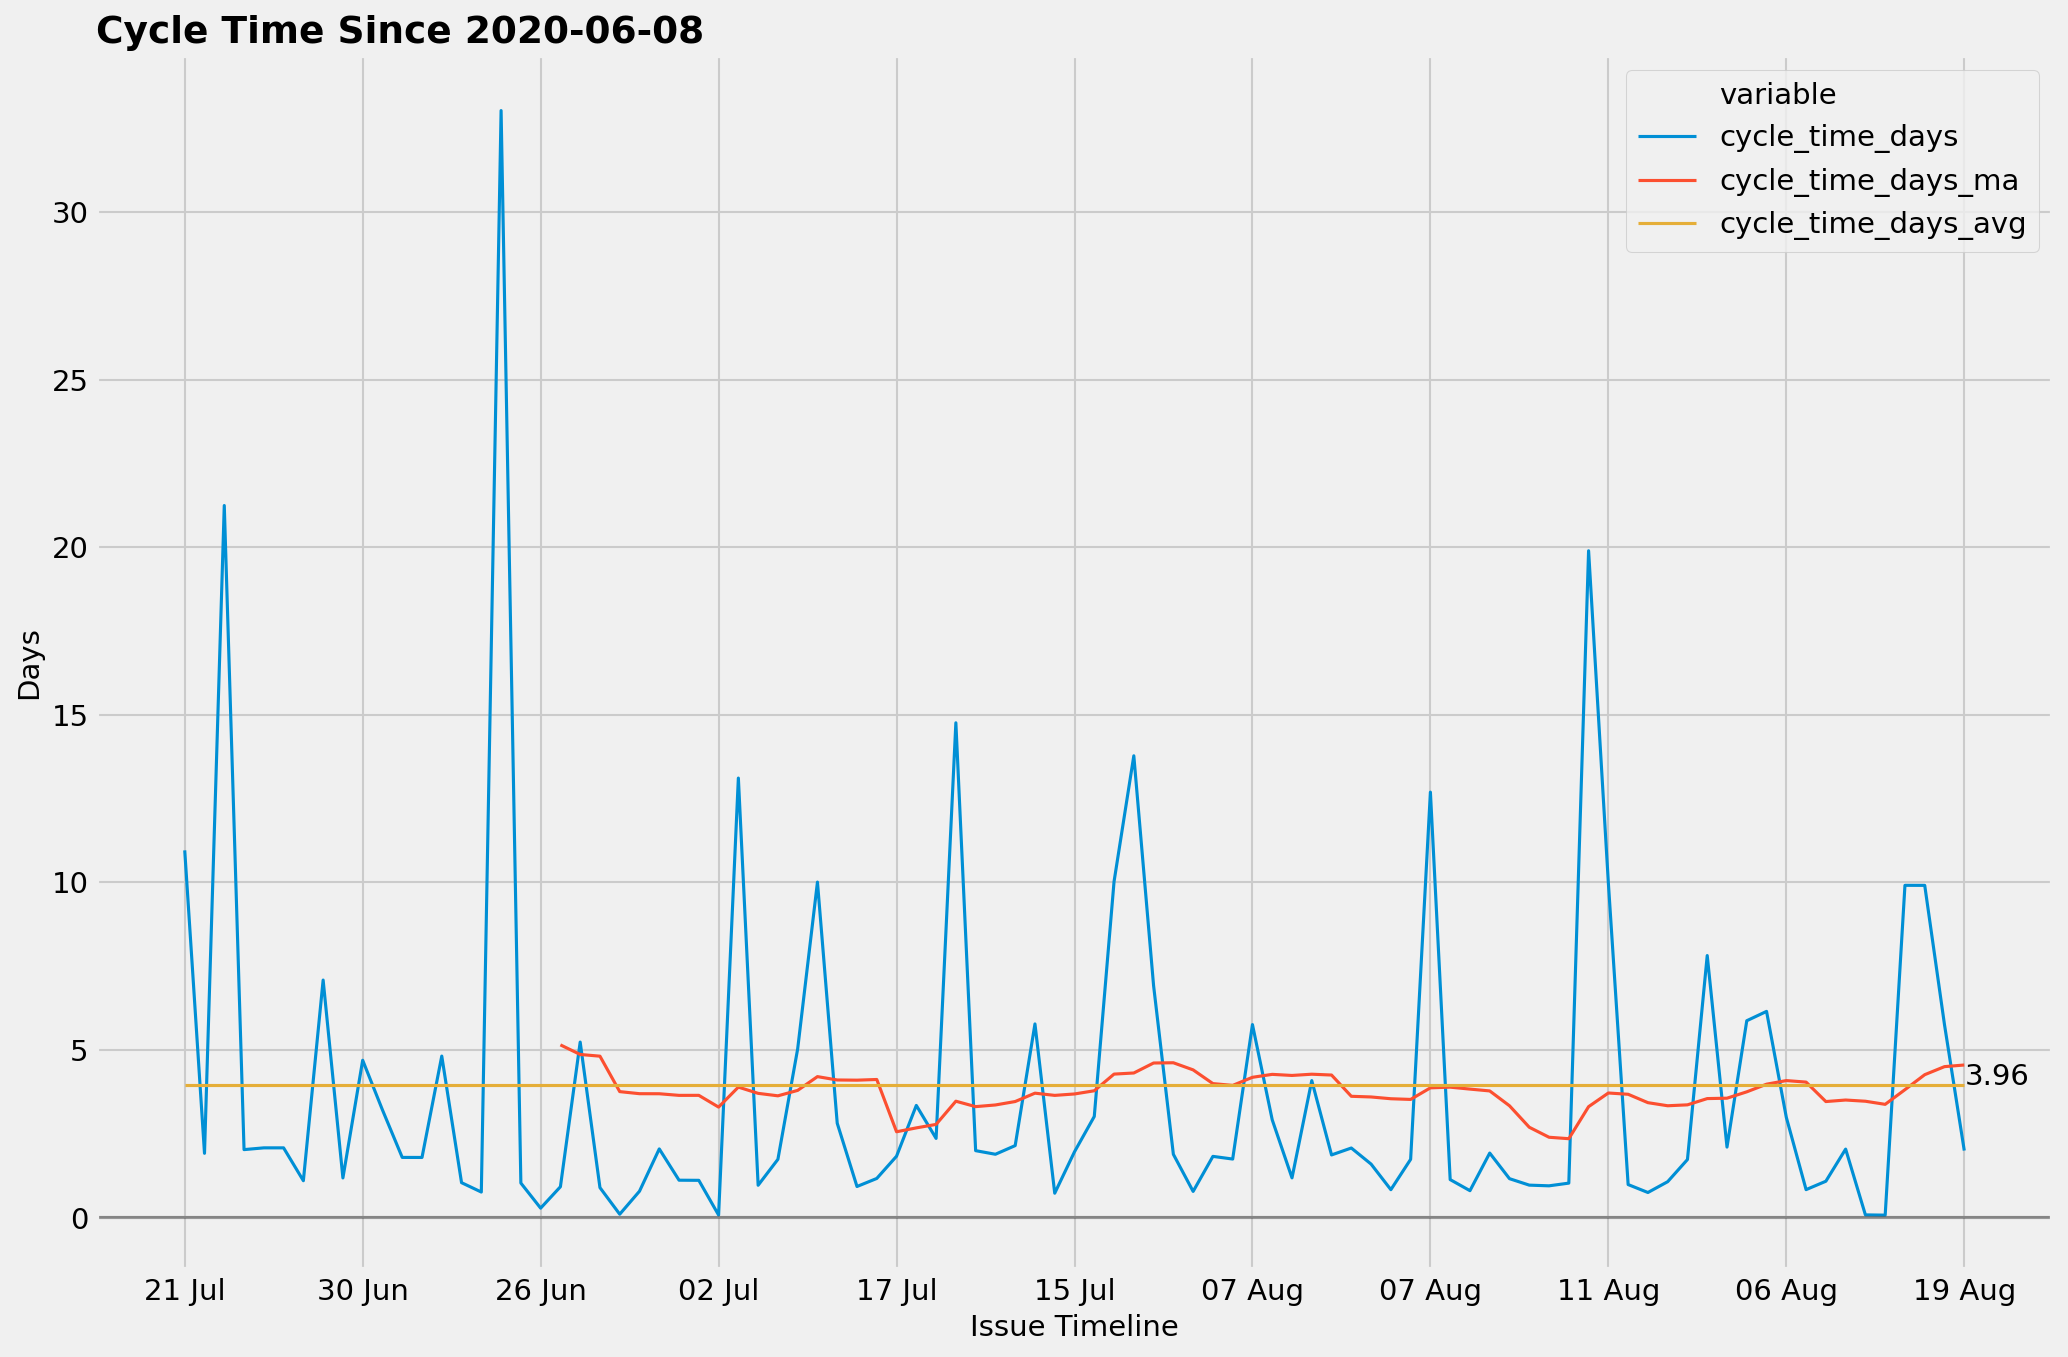

In [10]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.lineplot(x='issue_key', y='value', hue='variable', data=pandas.melt(cycle_data[['issue_key', 'cycle_time_days', 'cycle_time_days_ma', 'cycle_time_days_avg']], ['issue_key']))

ax.set_title("Cycle Time Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Issue Timeline')
ax.set_ylabel('Days')

key_ticks = range(0, len(cycle_data['issue_key']), len(cycle_data['issue_key'])//10)

ax.set_xticks(key_ticks)

def format_func(value, tick_number):
    return pandas.to_datetime(cycle_data['complete_day'].values[value]).strftime('%d %b')
ax.xaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))

ax.axhline(y=0, color=lightgrey, alpha=.5);

_ = ax.text(cycle_data['issue_key'].max(), cycle_data['cycle_time_days_avg'].max(), "{:.2f}".format(cycle_data['cycle_time_days_avg'].max()))

In [11]:
ax.figure.savefig('images/cycletime-timeline.png', dpi=150)

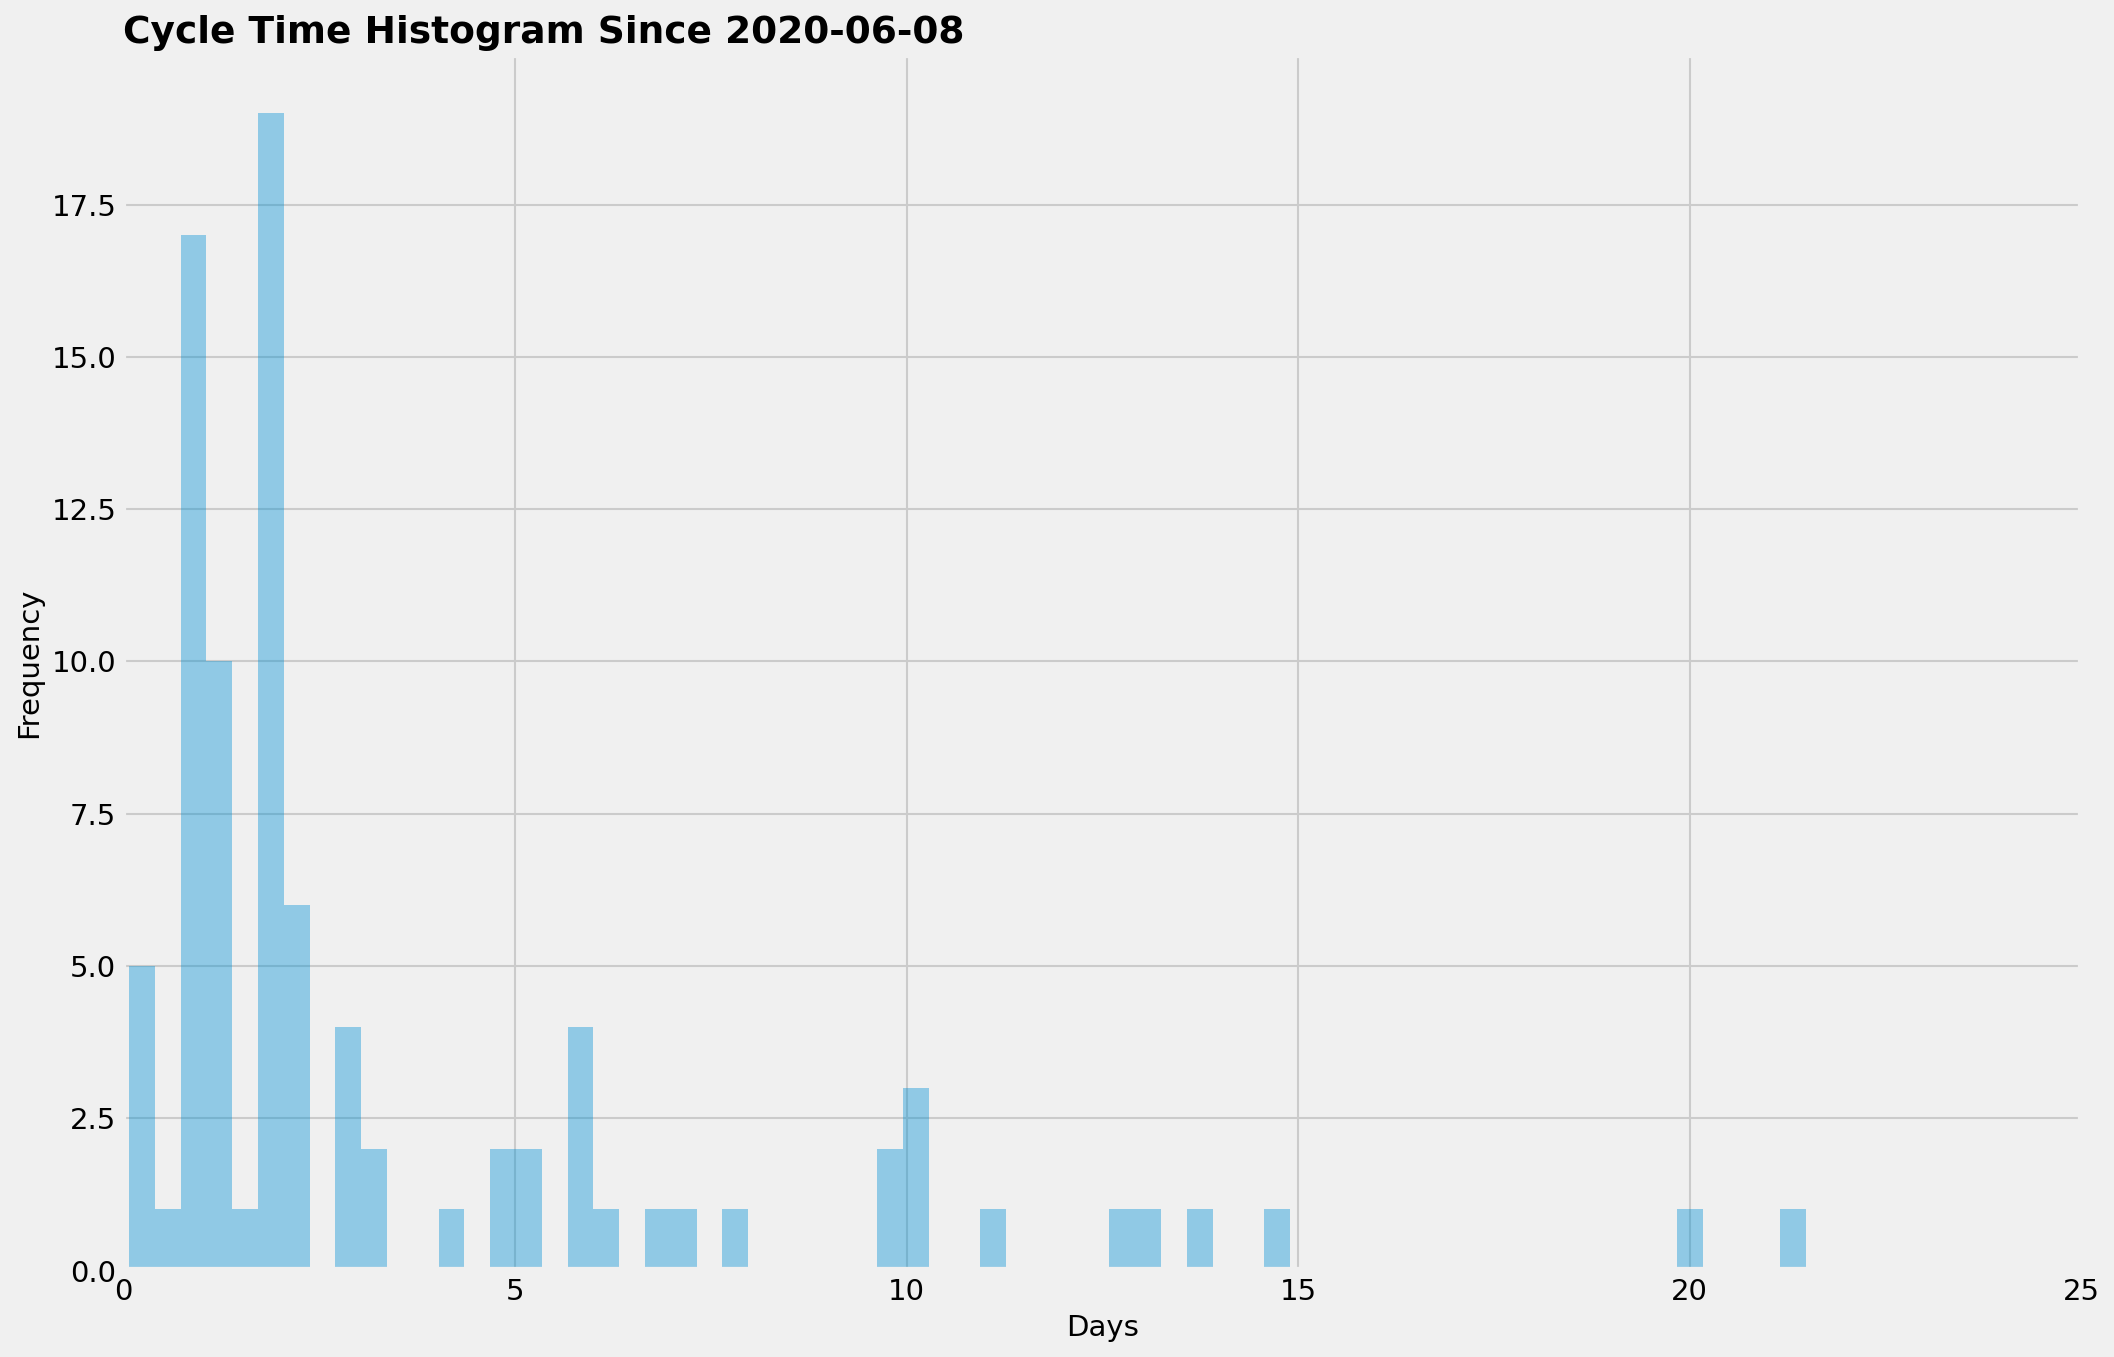

In [12]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.distplot(cycle_data['cycle_time_days'], bins=100, kde=False)

ax.set_title("Cycle Time Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_ylabel('Frequency')
ax.set_xlabel('Days')
_ = ax.set_xlim([0, 25])

In [13]:
ax.figure.savefig('images/cycletime-histogram.png')

### Throughput

Throughput is the number of issues completed in a given week.

In [14]:
throughput_data = issue_data.copy()
throughput_data = throughput_data[throughput_data['complete_day'] >= pandas.to_datetime(FILTER_ISSUES_SINCE)]

points_data = pandas.pivot_table(throughput_data, values='issue_points', index='complete_day', aggfunc=numpy.sum)

throughput = pandas.crosstab(throughput_data.complete_day, issue_data.issue_type, colnames=[None]).reset_index()

cols = set(throughput.columns)
cols.remove('complete_day')

throughput['Throughput'] = 0
for col in cols:
    throughput['Throughput'] += throughput[col]
    
date_range = pandas.date_range(
    start=throughput.complete_day.min(),
    end=throughput.complete_day.max(), freq='B'
)

throughput = throughput.set_index('complete_day')
throughput['Velocity'] = points_data['issue_points']

throughput = throughput.reindex(date_range).fillna(0).astype(int).rename_axis('Date')

In [15]:
throughput_per_week = pandas.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()
).reset_index()

throughput_per_week['Moving Average'] = throughput_per_week['Throughput'].rolling(window=4).mean().dropna()
throughput_per_week['Average'] = throughput_per_week['Throughput'].mean()

throughput_per_week.head(52)

,Date,Throughput,Moving Average,Average
0,2020-06-15,2,NaN,8.416667
1,2020-06-22,6,NaN,8.416667
2,2020-06-29,5,NaN,8.416667
3,2020-07-06,16,7.25,8.416667
4,2020-07-13,5,8.00,8.416667
5,2020-07-20,13,9.75,8.416667
6,2020-07-27,8,10.50,8.416667
7,2020-08-03,19,11.25,8.416667
8,2020-08-10,12,13.00,8.416667
9,2020-08-17,7,11.50,8.416667


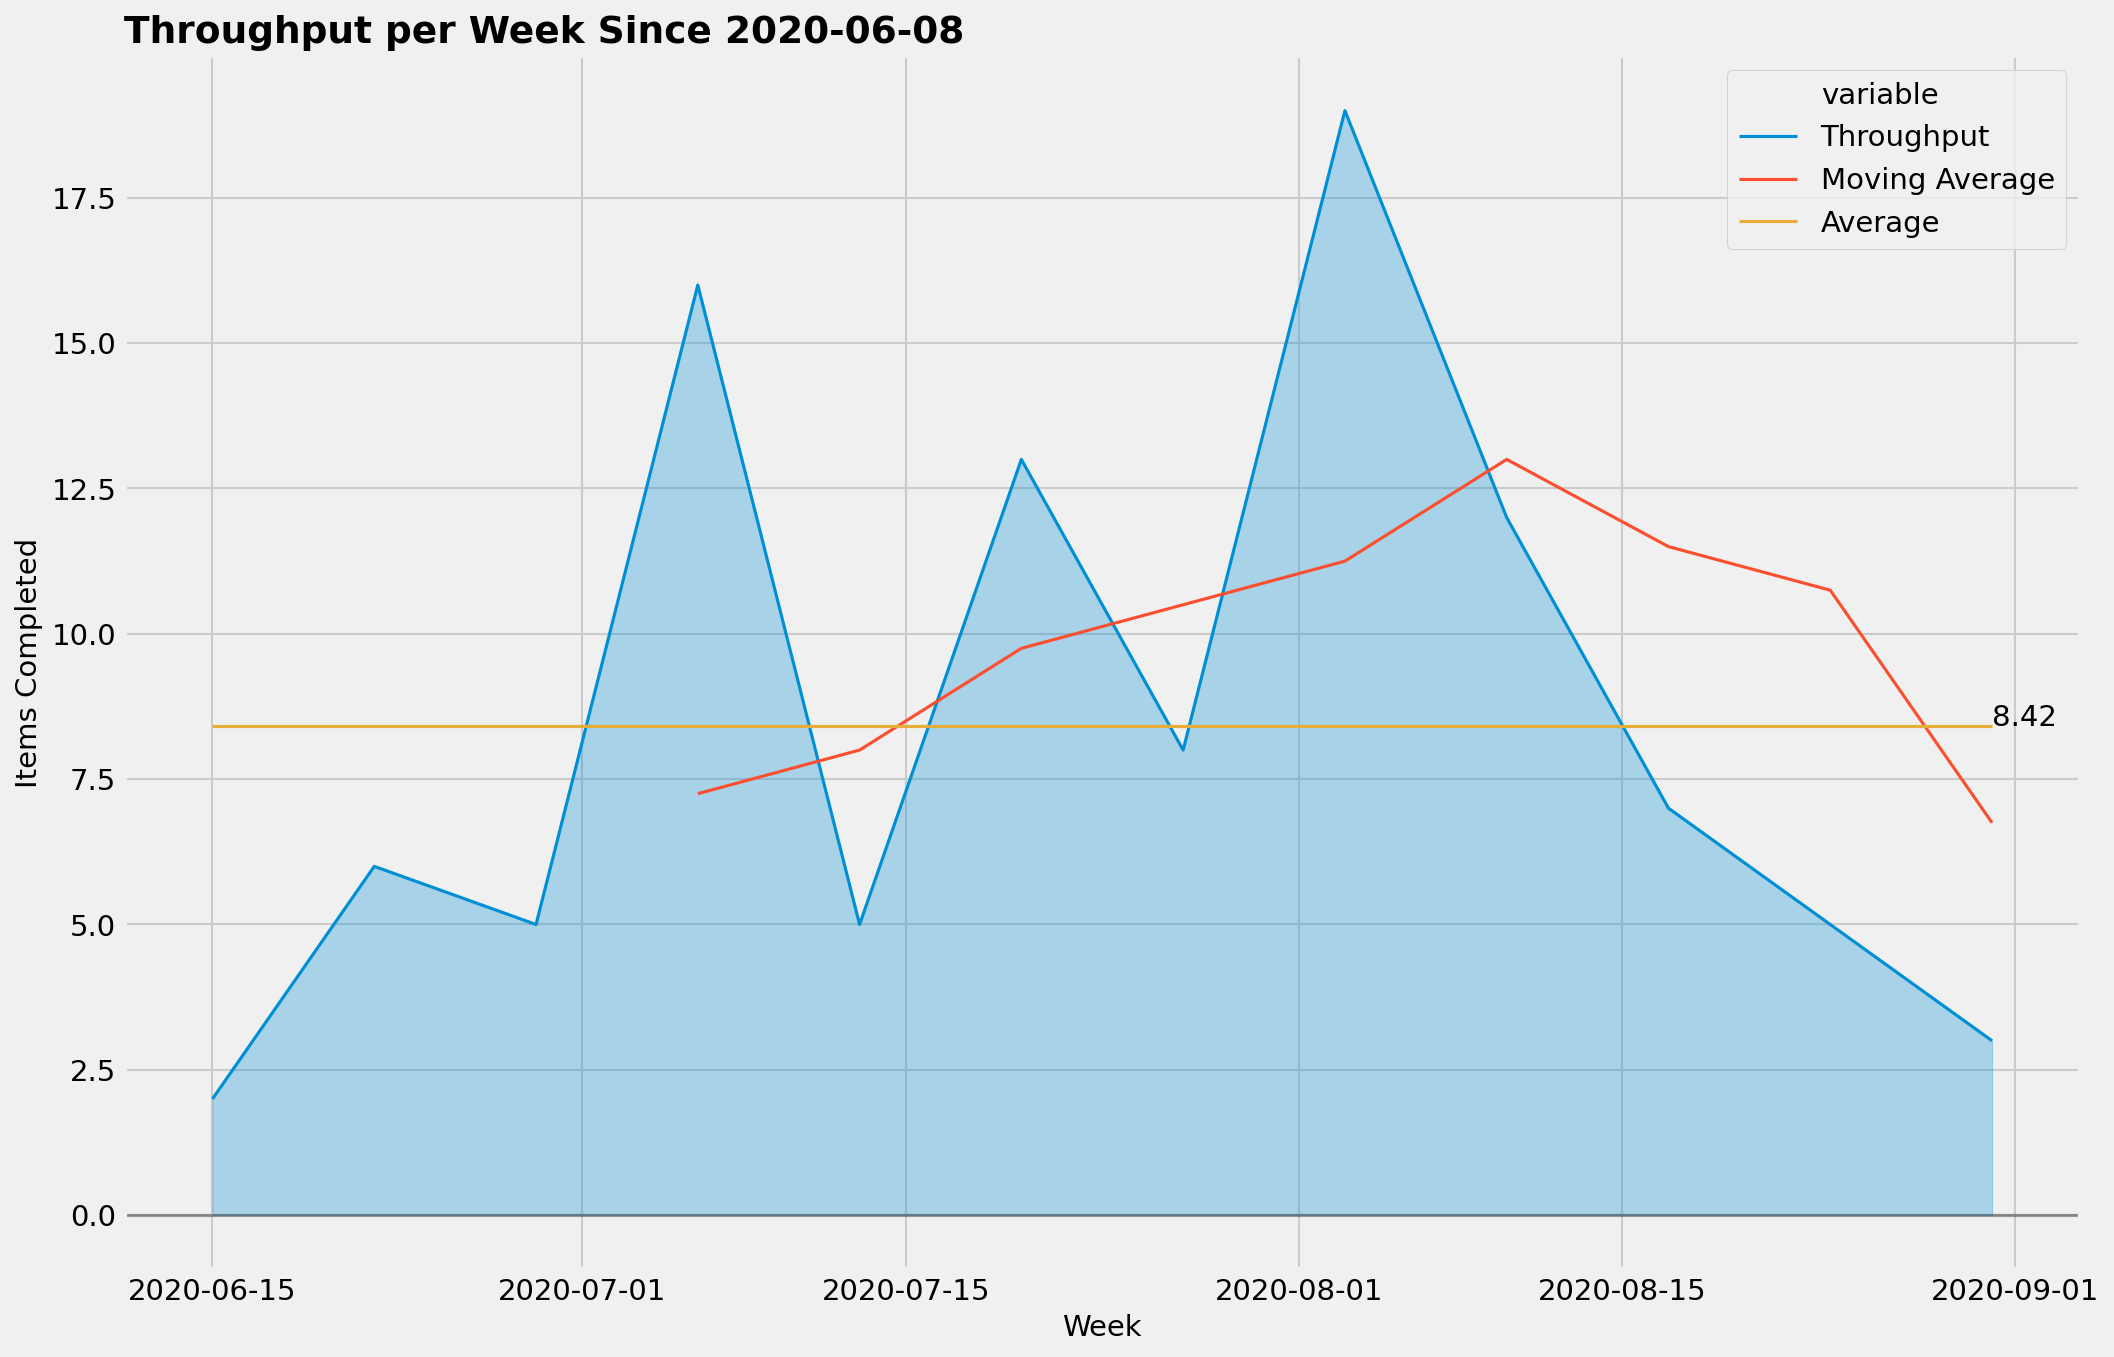

In [16]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='Date', y='value', hue='variable', data=pandas.melt(throughput_per_week[['Date', 'Throughput', 'Moving Average', 'Average']], ['Date']))

x = throughput_per_week['Date']
y1 = throughput_per_week['Throughput']
ax.fill_between(x, y1, color='C0', alpha=0.3,
                 interpolate=True)

ax.set_title("Throughput per Week Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Week')
ax.set_ylabel('Items Completed')

ax.axhline(y=0, color=lightgrey, alpha=.5);

_ = ax.text(throughput_per_week['Date'].max(), throughput_per_week['Average'].max(), "{:.2f}".format(throughput_per_week['Average'].max()))

In [17]:
ax.figure.savefig('images/throughput-timeline.png')

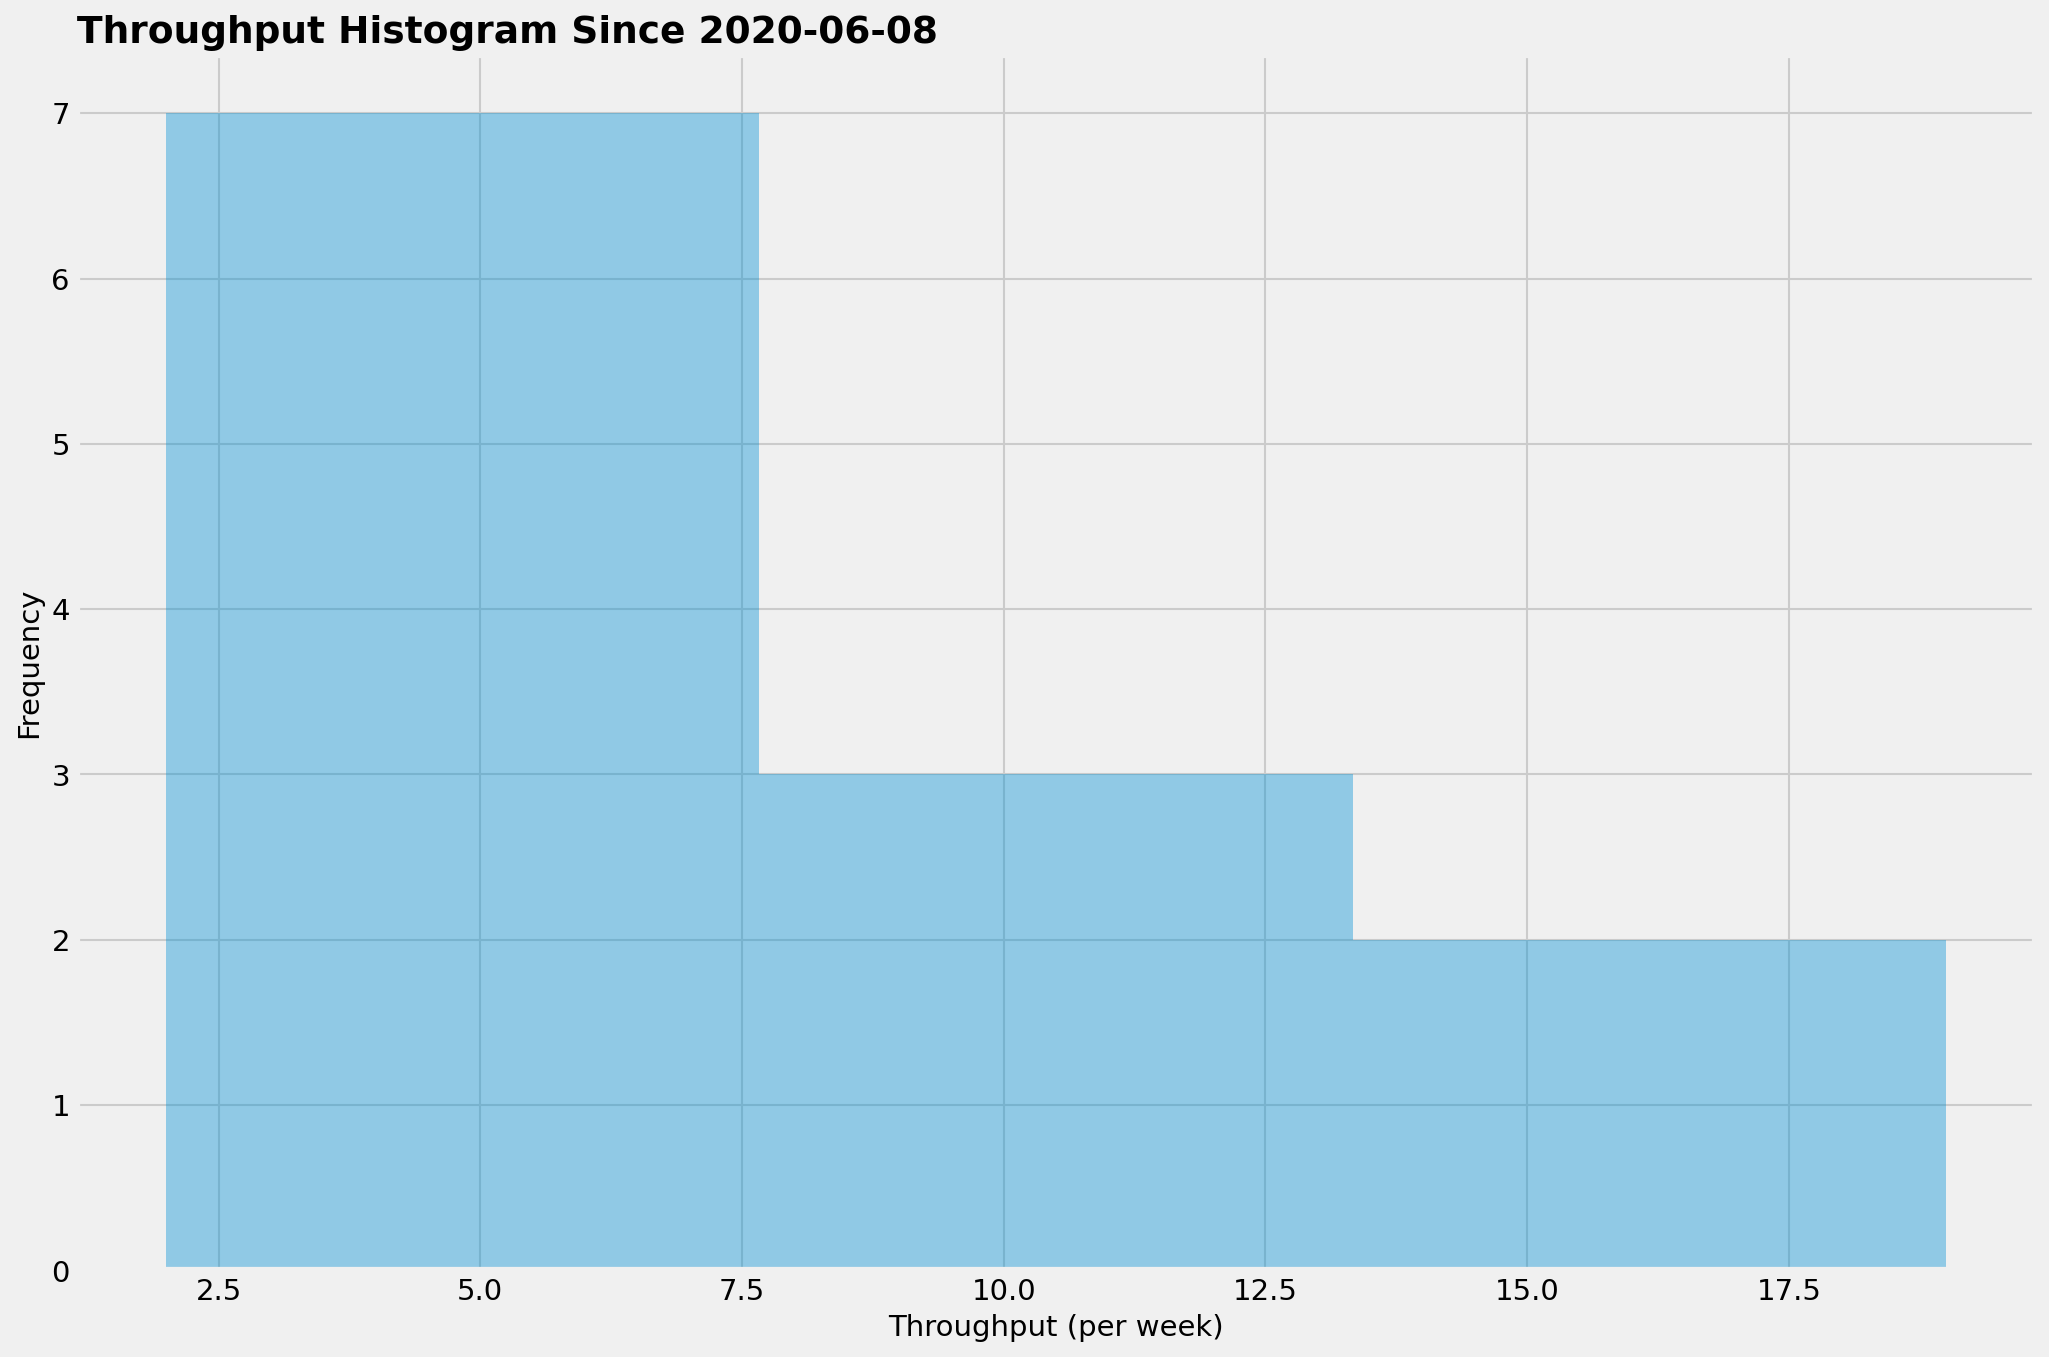

In [18]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.distplot(throughput_per_week['Throughput'], kde=False)

ax.set_title("Throughput Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Throughput (per week)')

In [19]:
ax.figure.savefig('images/throughput-histogram.png')

### Velocity

If we're pointing issues, we can use the points as our throughput metric instead of number of issues closed. This is not a traditional Kanban practice, but it's useful for some teams. If you've loaded data that does not include a point metric, we assume 1 point per issue.

In [20]:
velocity_per_week = pandas.DataFrame(
    throughput['Velocity'].resample('2W-Mon', closed='right').sum()
).reset_index()

velocity_per_week['Moving Average'] = velocity_per_week['Velocity'].rolling(window=4).mean().dropna()
velocity_per_week['Average'] = velocity_per_week['Velocity'].mean()

velocity_per_week.head(52)

,Date,Velocity,Moving Average,Average
0,2020-06-15,2,NaN,14.428571
1,2020-06-29,11,NaN,14.428571
2,2020-07-13,21,NaN,14.428571
3,2020-07-27,21,13.75,14.428571
4,2020-08-10,31,21.00,14.428571
5,2020-08-24,12,21.25,14.428571
6,2020-09-07,3,16.75,14.428571


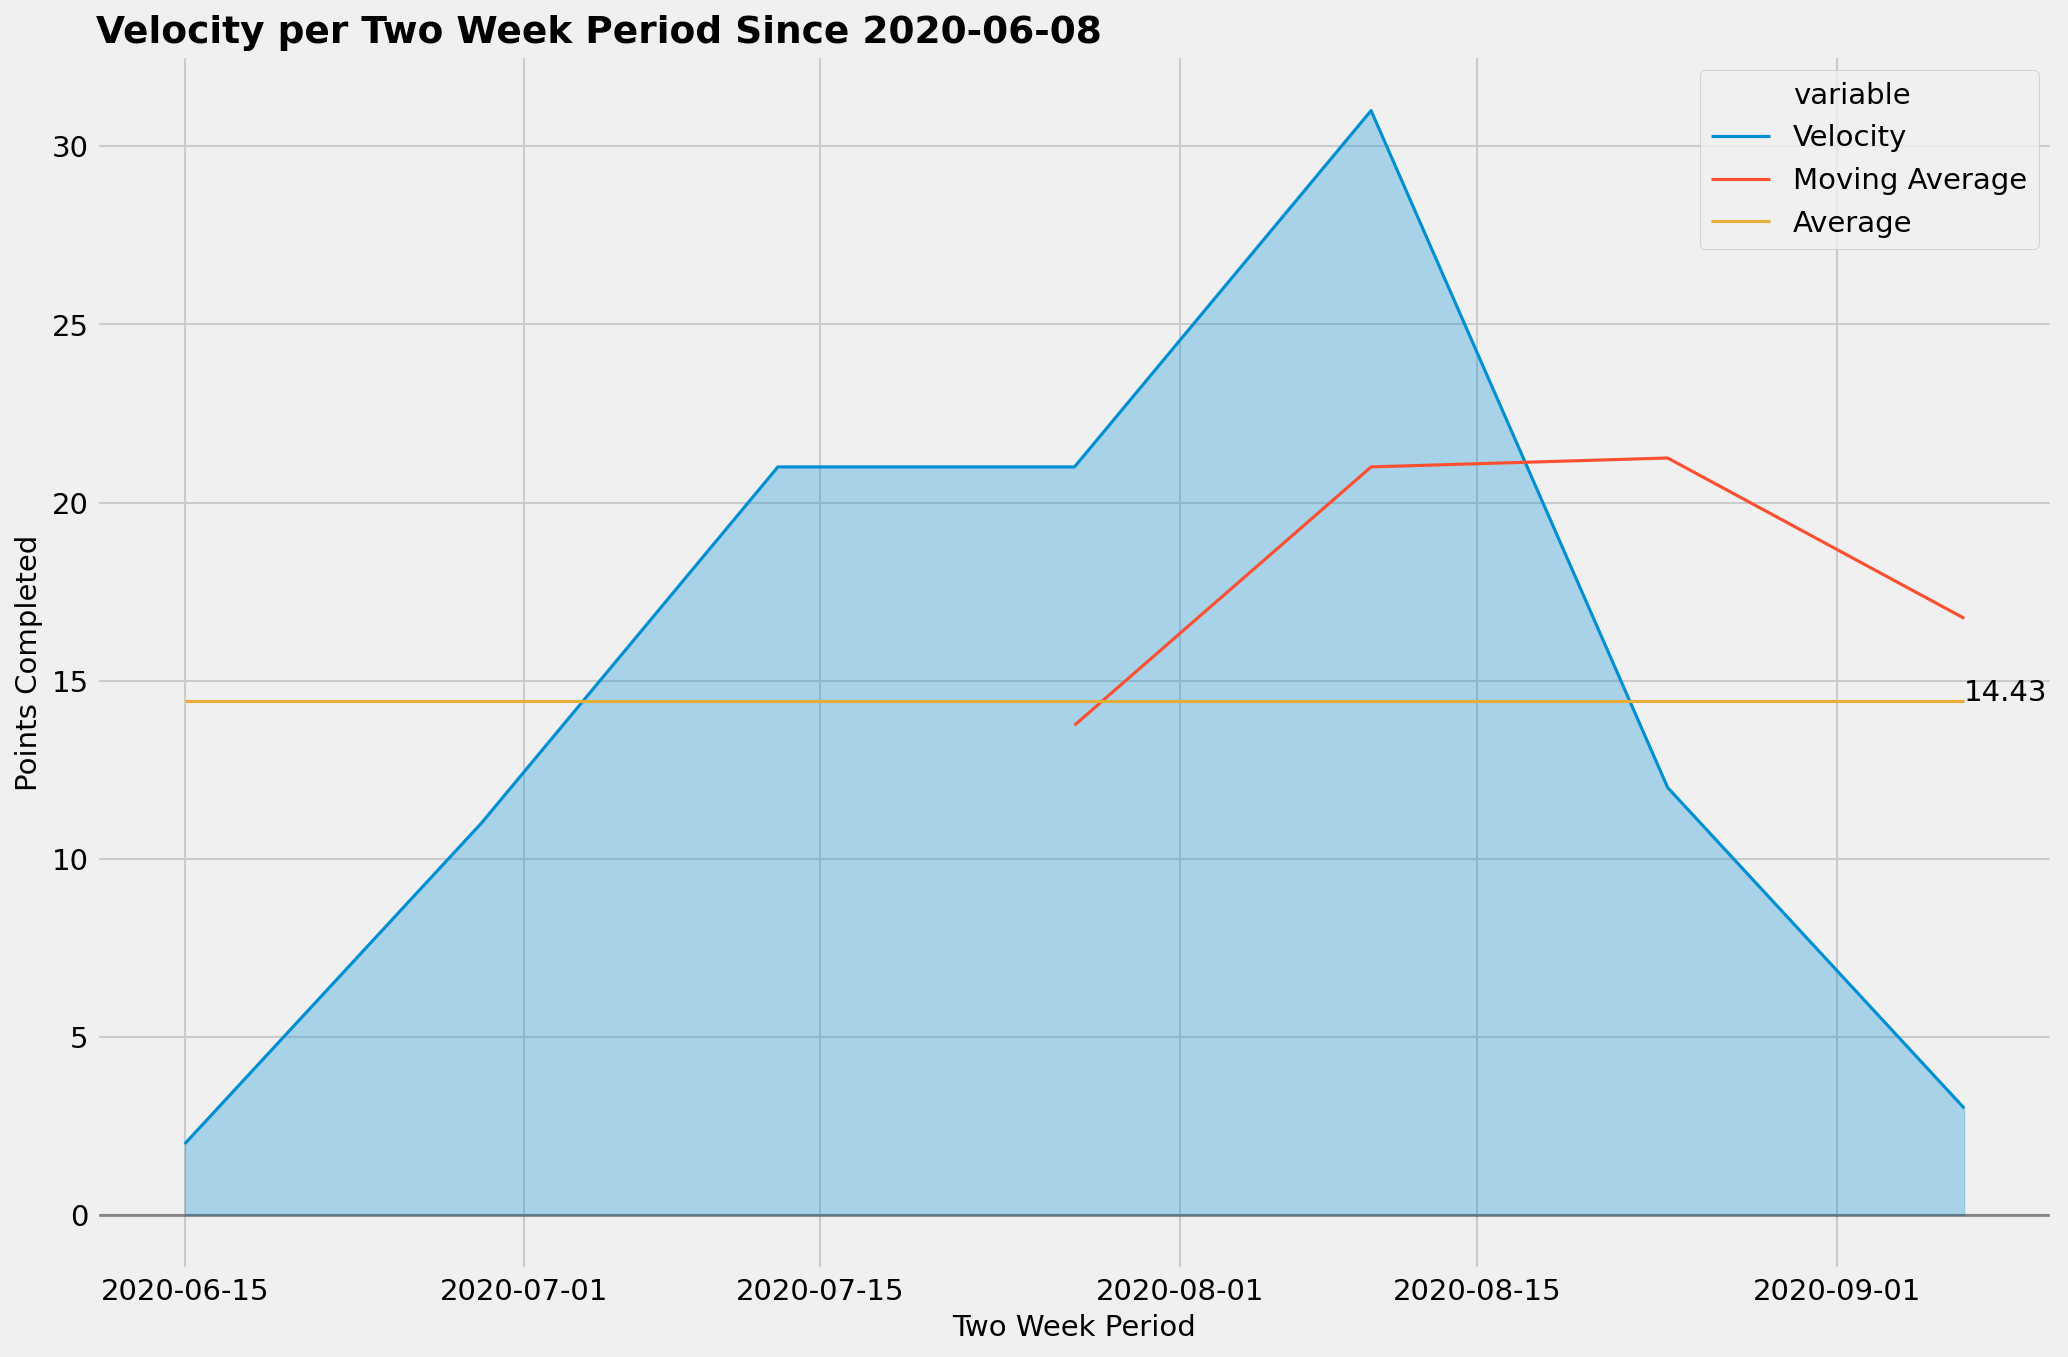

In [21]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='Date', y='value', hue='variable', data=pandas.melt(velocity_per_week[['Date', 'Velocity', 'Moving Average', 'Average']], ['Date']))

x = velocity_per_week['Date']
y1 = velocity_per_week['Velocity']
ax.fill_between(x, y1, color='C0', alpha=0.3,
                 interpolate=True)

ax.set_title("Velocity per Two Week Period Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Two Week Period')
ax.set_ylabel('Points Completed')

ax.axhline(y=0, color=lightgrey, alpha=.5);

_ = ax.text(velocity_per_week['Date'].max(), velocity_per_week['Average'].max(), "{:.2f}".format(velocity_per_week['Average'].max()))

In [22]:
ax.figure.savefig('images/velocity-timeline.png', dpi=150)

### Arrivals & Departures

Let's check out the arrivals and departures in the flow.

In [23]:
start = pandas.to_datetime(FILTER_ISSUES_SINCE)
end = pandas.to_datetime('today')

wip_data = []

while start <= end:
    
    wip_data.append({
        'date': start,
        'arrivals': (issue_data['new_day'] == start).sum(),
        'departures': (issue_data['complete_day'] == start).sum(),
    })
    
    start += pandas.Timedelta(days=1)

wip_data = pandas.DataFrame(wip_data, columns=['date', 'arrivals', 'departures'])

wip_data.head()

,date,arrivals,departures
0,2020-06-08,1,0
1,2020-06-09,3,0
2,2020-06-10,0,0
3,2020-06-11,4,0
4,2020-06-12,2,0


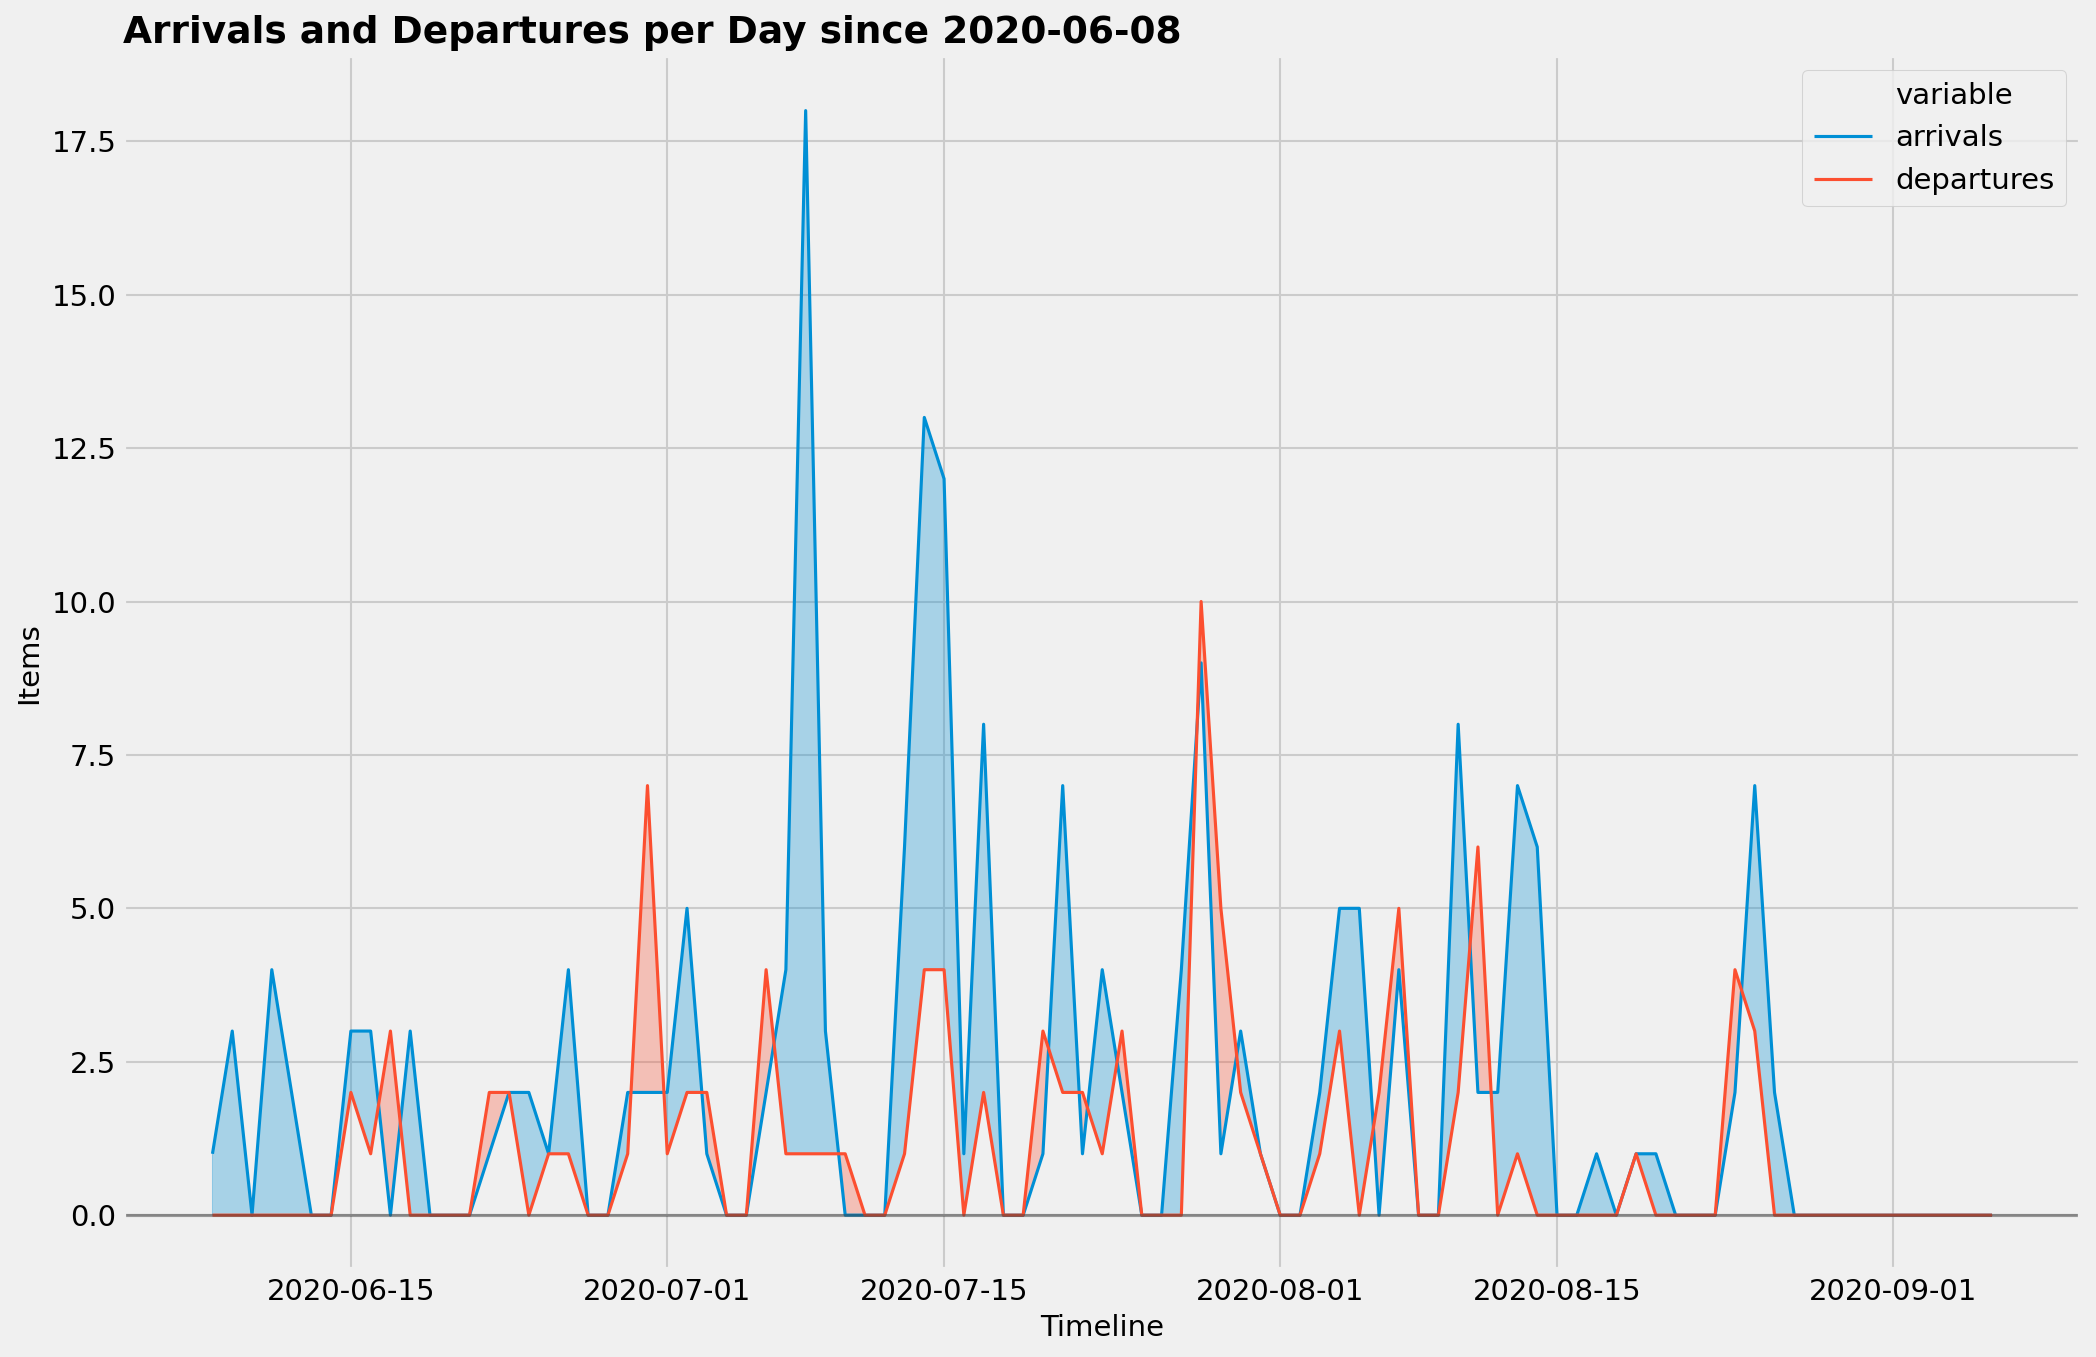

In [24]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='date', y='value', hue='variable', data=pandas.melt(wip_data[['date', 'arrivals', 'departures']], ['date']))

x = wip_data['date']
y1 = wip_data['arrivals']
y2 = wip_data['departures']

ax.fill_between(x, y1, y2, where=(y1 > y2), color='C0', alpha=0.3,
                 interpolate=True)

ax.fill_between(x, y1, y2, where=(y1 <= y2), color='C1', alpha=0.3,
                 interpolate=True)

ax.set_title(f"Arrivals and Departures per Day since {wip_data['date'].min().strftime('%Y-%m-%d')}", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Items')

ax.axhline(y=0, color=lightgrey, alpha=.5);

In [25]:
ax.figure.savefig('images/burndown-timeline.png')

### Cumulative Flow

Understanding the flow of issues in each status is important for understanding where bottlenecks occur.

In [26]:
dates = pandas.date_range(start=FILTER_ISSUES_SINCE, end='today', freq='D', tz='UTC')

flow_data = data.copy().reset_index()

statuses = set(flow_data['status_from_name']) | set(flow_data['status_to_name'])
statuses.remove(numpy.nan)

f = pandas.DataFrame(columns=['date'] + list(statuses))

last_counter = None

for date in dates:
    tomorrow = date + pandas.Timedelta(days=1)
    date_changes = flow_data
    date_changes = date_changes[date_changes['status_change_date'] >= date]
    date_changes = date_changes[date_changes['status_change_date'] < tomorrow]
    
    if last_counter:
        counter = last_counter
    else:
        counter = collections.Counter()
    for item in date_changes['status_from_name']:
        if counter[item] > 0:
            counter[item] -= 1
    for item in date_changes['status_to_name']:
        counter[item] += 1
    
    row = dict(counter)
    row['date'] = date
    f = f.append(row, ignore_index=True)
    
    last_counter = counter

f = f.fillna(0)
f['date'] = f['date'].dt.normalize()
f['date'] = f['date'].dt.date
f.head()

,date,Prioritized,Review,To Do,Backlog,In Preparation,In Progress,Accepted,Deployed,Can't Fix
0,2020-06-08,1,0,0,0,0,0,1,0,0
1,2020-06-09,3,0,1,0,0,0,1,0,0
2,2020-06-10,3,0,1,0,0,0,1,0,0
3,2020-06-11,4,0,0,0,0,1,1,0,0
4,2020-06-12,4,0,0,0,0,1,1,0,0


In [27]:
ending_status = STATUS_ORDER[-1]
status_columns = list(reversed(STATUS_ORDER))
flow_columns = ['date'] + status_columns

flow = f[flow_columns]

y_min = flow[ending_status].min()
y_max = flow[STATUS_ORDER].max().sum()

flow.head()

,date,Deployed,Accepted,Review,In Progress,In Preparation,Prioritized
0,2020-06-08,0,1,0,0,0,1
1,2020-06-09,0,1,0,0,0,3
2,2020-06-10,0,1,0,0,0,3
3,2020-06-11,0,1,0,1,0,4
4,2020-06-12,0,1,0,1,0,4


In [28]:
# custom area plot data
flow_agg = flow[flow_columns]
x  = flow_agg['date'] = pandas.to_datetime(flow_agg['date'])

ys = []
for status in reversed(STATUS_ORDER):
    lasty = ys[-1] if ys else 0
    y = flow_agg[status] = (flow_agg[status] + lasty).astype(float)
    ys.append(y)
    
# melt the data to be able to be sent to lineplot
xyz = pandas.melt(flow_agg, ['date'])
xyz['value'] = xyz['value'].astype(float)

(-15.4, 184.8)

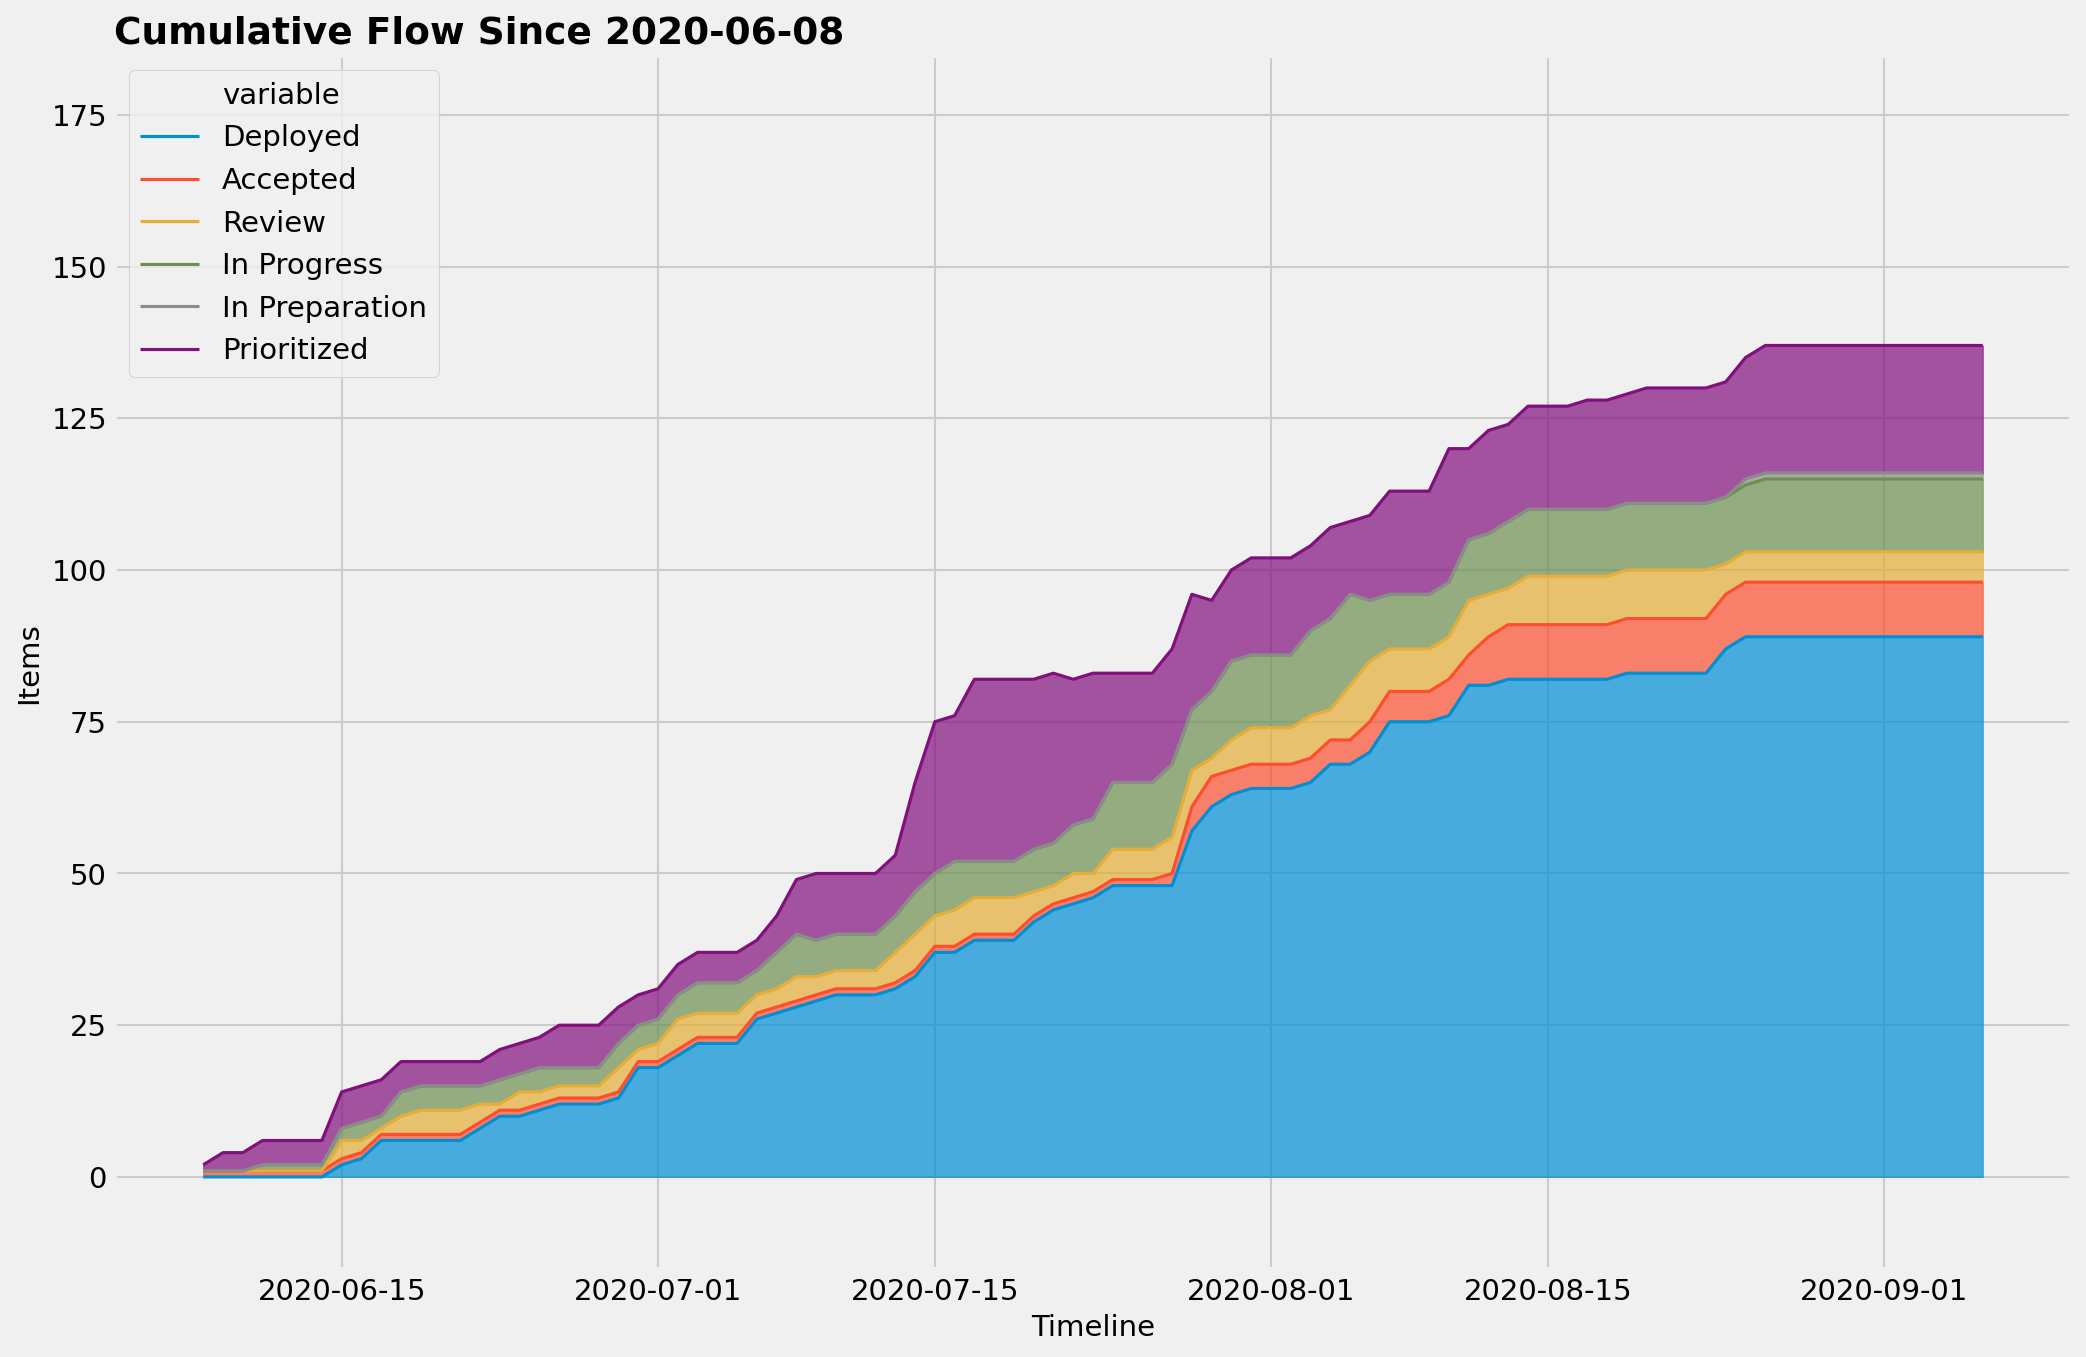

In [29]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='date', y='value', hue='variable', data=xyz)

# create the area fills between lines
lasty = 0
for i, y in enumerate(ys):
    ax.fill_between(x, lasty, y, color=f'C{i}', alpha=0.7,
        interpolate=False)
    lasty = y

ax.set_title("Cumulative Flow Since {}".format(flow_agg['date'].min().strftime('%Y-%m-%d')), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Items')

tenth = (y_max-y_min)*0.1

ax.set_ylim([y_min - tenth, y_max + 2*tenth])

In [30]:
ax.figure.savefig('images/flow-timeline.png')

In [31]:
# custom area plot data
flow_agg = flow[flow_columns]
x  = flow_agg['date'] = pandas.to_datetime(flow_agg['date'])

# create the aggregations based on the (reversed) status order
flow_agg[status_columns] = flow_agg[status_columns].divide(flow_agg[status_columns].sum(axis=1), axis=0)

ys = []
for status in reversed(STATUS_ORDER):
    lasty = ys[-1] if ys else 0
    y = flow_agg[status] = (flow_agg[status] + lasty).astype(float)
    ys.append(y)
    
# melt the data to be able to be sent to lineplot
xyz = pandas.melt(flow_agg, ['date'])
xyz['value'] = xyz['value'].astype(float)

Text(0, 0.5, 'Items Percent')

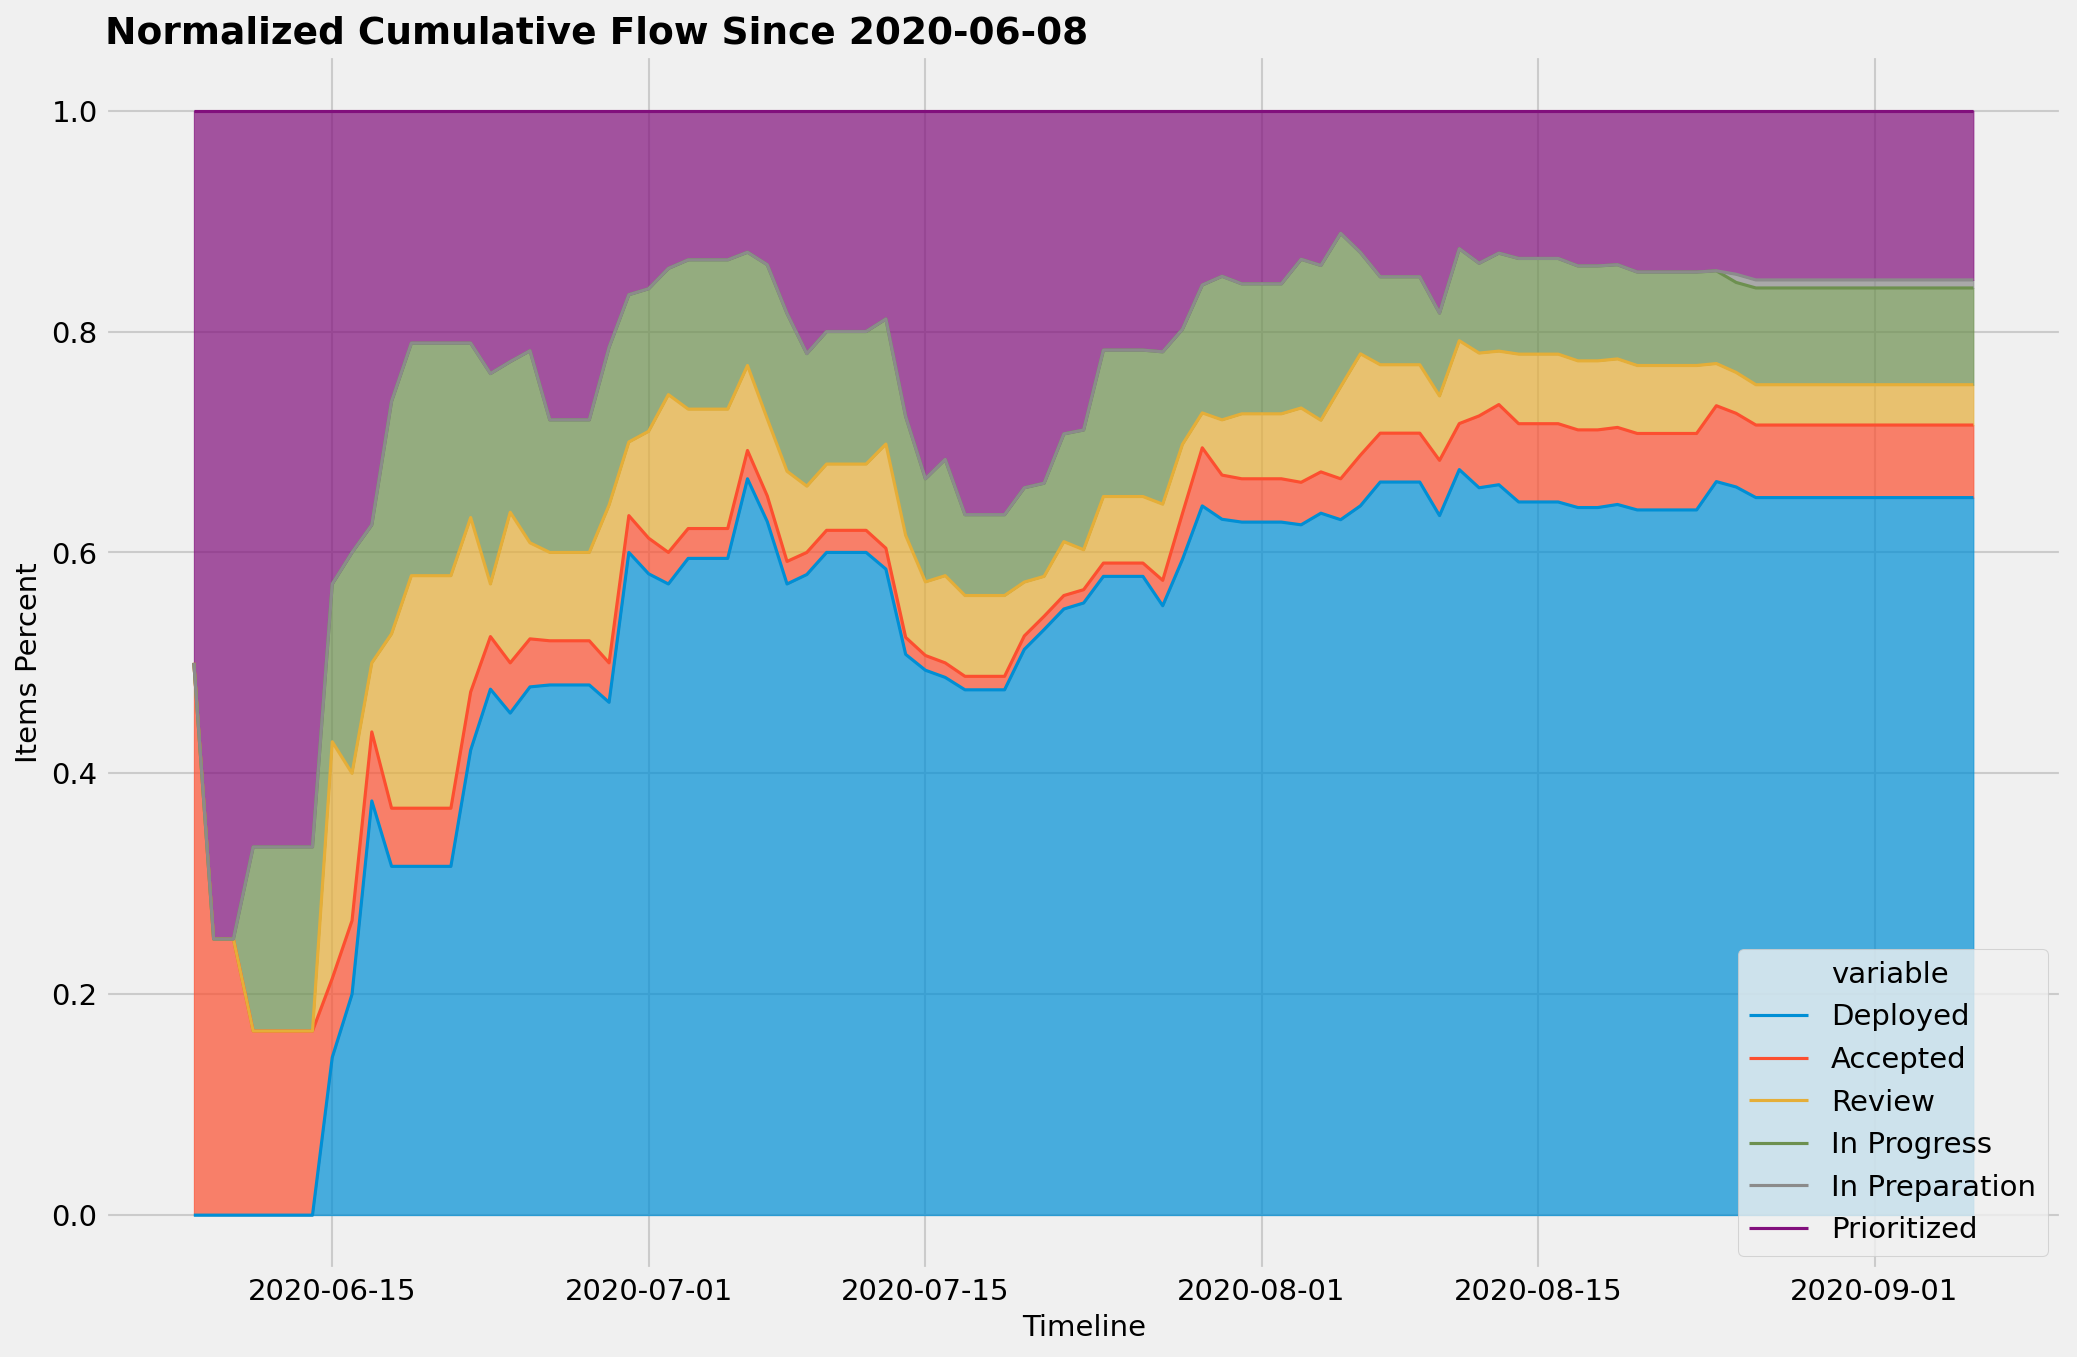

In [32]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='date', y='value', hue='variable', data=xyz)

# create the area fills between lines
lasty = 0
for i, y in enumerate(ys):
    ax.fill_between(x, lasty, y, color=f'C{i}', alpha=0.7,
        interpolate=False)
    lasty = y

ax.set_title("Normalized Cumulative Flow Since {}".format(flow_agg['date'].min().strftime('%Y-%m-%d')), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Items Percent')

In [33]:
ax.figure.savefig('images/flow-normalized-timeline.png')

### Work In Progress Aging

We should also keep track of work in progress as it ages.

In [34]:
age_data = issue_data[issue_data['in_progress_day'].notnull()]
age_data = age_data[age_data['complete_day'].isnull()]
age_data = age_data[age_data['last_issue_status_category'] != 'To Do']

today = pandas.to_datetime('today')
age_data['wip_age_days'] = (today - age_data['in_progress']) / pandas.to_timedelta(1, unit='D')

age_data['wip_age_mean'] = age_data['wip_age_days'].mean()
age_data['wip_age_P50'] = age_data['wip_age_days'].quantile(0.5)
age_data['wip_age_P75'] = age_data['wip_age_days'].quantile(0.75)
age_data['wip_age_P95'] = age_data['wip_age_days'].quantile(0.95)

age_data.head(n=len(age_data))

,issue_key,issue_type,issue_points,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days,last_issue_status,last_issue_status_category,wip_age_days,wip_age_mean,wip_age_P50,wip_age_P75,wip_age_P95
29,PRJ-1211,Bug,1,2020-06-29 14:12:48.768,2020-06-29,2020-08-05 18:34:09.100000,2020-08-05,None,NaT,0 days,0.0,0 days,0.0,Accepted,In Progress,32.081145,27.693163,26.618932,33.9061,40.358946
53,PRJ-1236,Task,1,2020-07-08 15:13:21.343,2020-07-08,2020-08-10 19:24:06.606000,2020-08-10,None,NaT,0 days,0.0,0 days,0.0,In Progress,In Progress,27.046452,27.693163,26.618932,33.9061,40.358946
84,PRJ-1269,Story,1,2020-07-14 19:57:34.044,2020-07-14,2020-07-29 10:37:31.602000,2020-07-29,None,NaT,0 days,0.0,0 days,0.0,Accepted,In Progress,39.412135,27.693163,26.618932,33.9061,40.358946
96,PRJ-1283,Task,1,2020-07-15 20:24:47.855,2020-07-15,2020-08-13 15:01:09.583000,2020-08-13,None,NaT,0 days,0.0,0 days,0.0,In Progress,In Progress,24.229056,27.693163,26.618932,33.9061,40.358946
99,PRJ-1290,Task,1,2020-07-16 10:33:09.955,2020-07-16,2020-08-04 15:27:21.879000,2020-08-04,None,NaT,0 days,0.0,0 days,0.0,Review,In Progress,33.210859,27.693163,26.618932,33.9061,40.358946
107,PRJ-1298,Bug,1,2020-07-17 16:28:22.261,2020-07-17,2020-07-27 16:34:12.085000,2020-07-27,None,NaT,0 days,0.0,0 days,0.0,Accepted,In Progress,41.164444,27.693163,26.618932,33.9061,40.358946
109,PRJ-1300,Bug,1,2020-07-21 12:40:29.959,2020-07-21,2020-08-11 21:44:48.811000,2020-08-11,None,NaT,0 days,0.0,0 days,0.0,Accepted,In Progress,25.948741,27.693163,26.618932,33.9061,40.358946
110,PRJ-1301,Bug,1,2020-07-21 12:55:44.045,2020-07-21,2020-07-30 16:33:06.487000,2020-07-30,None,NaT,0 days,0.0,0 days,0.0,Accepted,In Progress,38.165203,27.693163,26.618932,33.9061,40.358946
112,PRJ-1303,Story,1,2020-07-21 15:45:14.997,2020-07-21,2020-08-11 15:42:59.965000,2020-08-11,None,NaT,0 days,0.0,0 days,0.0,In Progress,In Progress,26.200001,27.693163,26.618932,33.9061,40.358946
129,PRJ-1322,Story,1,2020-07-28 15:18:30.882,2020-07-28,2020-07-28 15:18:48.648000,2020-07-28,None,NaT,0 days,0.0,0 days,0.0,In Progress,In Progress,40.216799,27.693163,26.618932,33.9061,40.358946


Text(0, 0.5, 'Days')

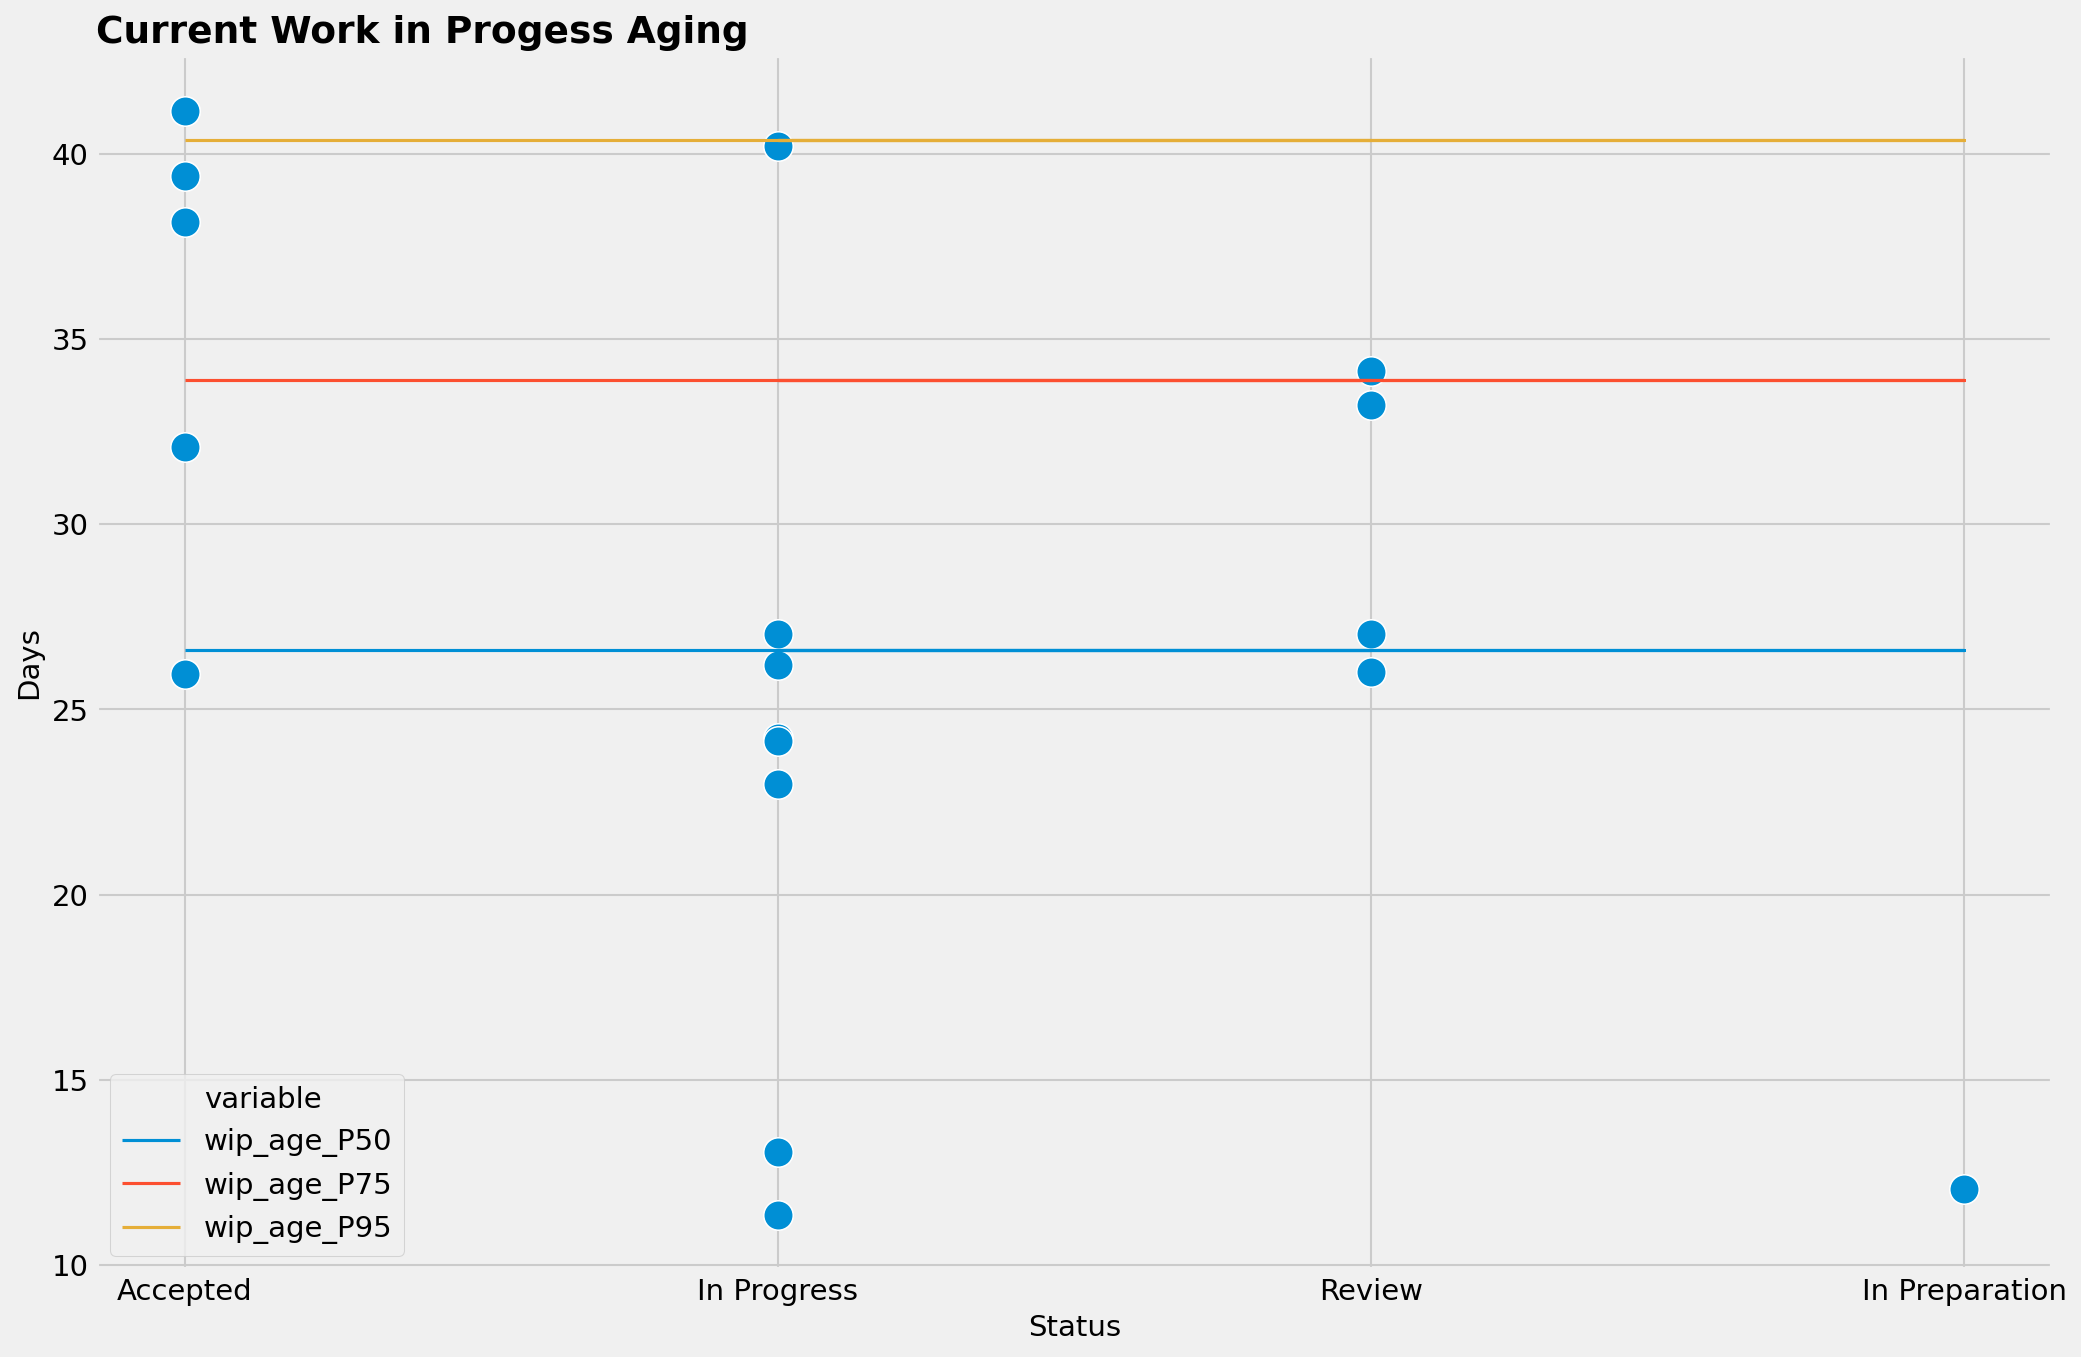

In [35]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.scatterplot(x='last_issue_status', y='wip_age_days', data=age_data, s=200, sizes=(200, 200))

ax = seaborn.lineplot(x='last_issue_status', y='value', hue='variable', dashes=True, data=pandas.melt(age_data[['last_issue_status', 'wip_age_P50', 'wip_age_P75', 'wip_age_P95']], ['last_issue_status']), ax=ax)

ax.set_title("Current Work in Progess Aging", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Status')
ax.set_ylabel('Days')

In [36]:
ax.figure.savefig('images/wip-aging.png')

---

## Forecasting

Welcome to the main event. Let's try to forecast the future completion of issues based on the historical distribution of throughput.

### Kaplan-Meier Surviability

To forecast the probability of completion for a single issue, we can use our historical cycle time data and fit it into a Kaplan-Meier survivability curve.

This model will allow us to forecast the probability of a single issue having a cycle time longer than a particular value (i.e., surviving past a point in time):

In [37]:
from lifelines import KaplanMeierFitter

survivability_data = issue_data.copy()
survivability_data = survivability_data[survivability_data['complete_day'] >= pandas.to_datetime(FILTER_ISSUES_SINCE)]

durations = survivability_data['cycle_time_days']
event_observed = [1 if c else 0 for c in survivability_data['cycle_time_days']]

km = KaplanMeierFitter()

## Fit the data into the model
model = km.fit(durations, event_observed,label='Kaplan Meier Estimate')

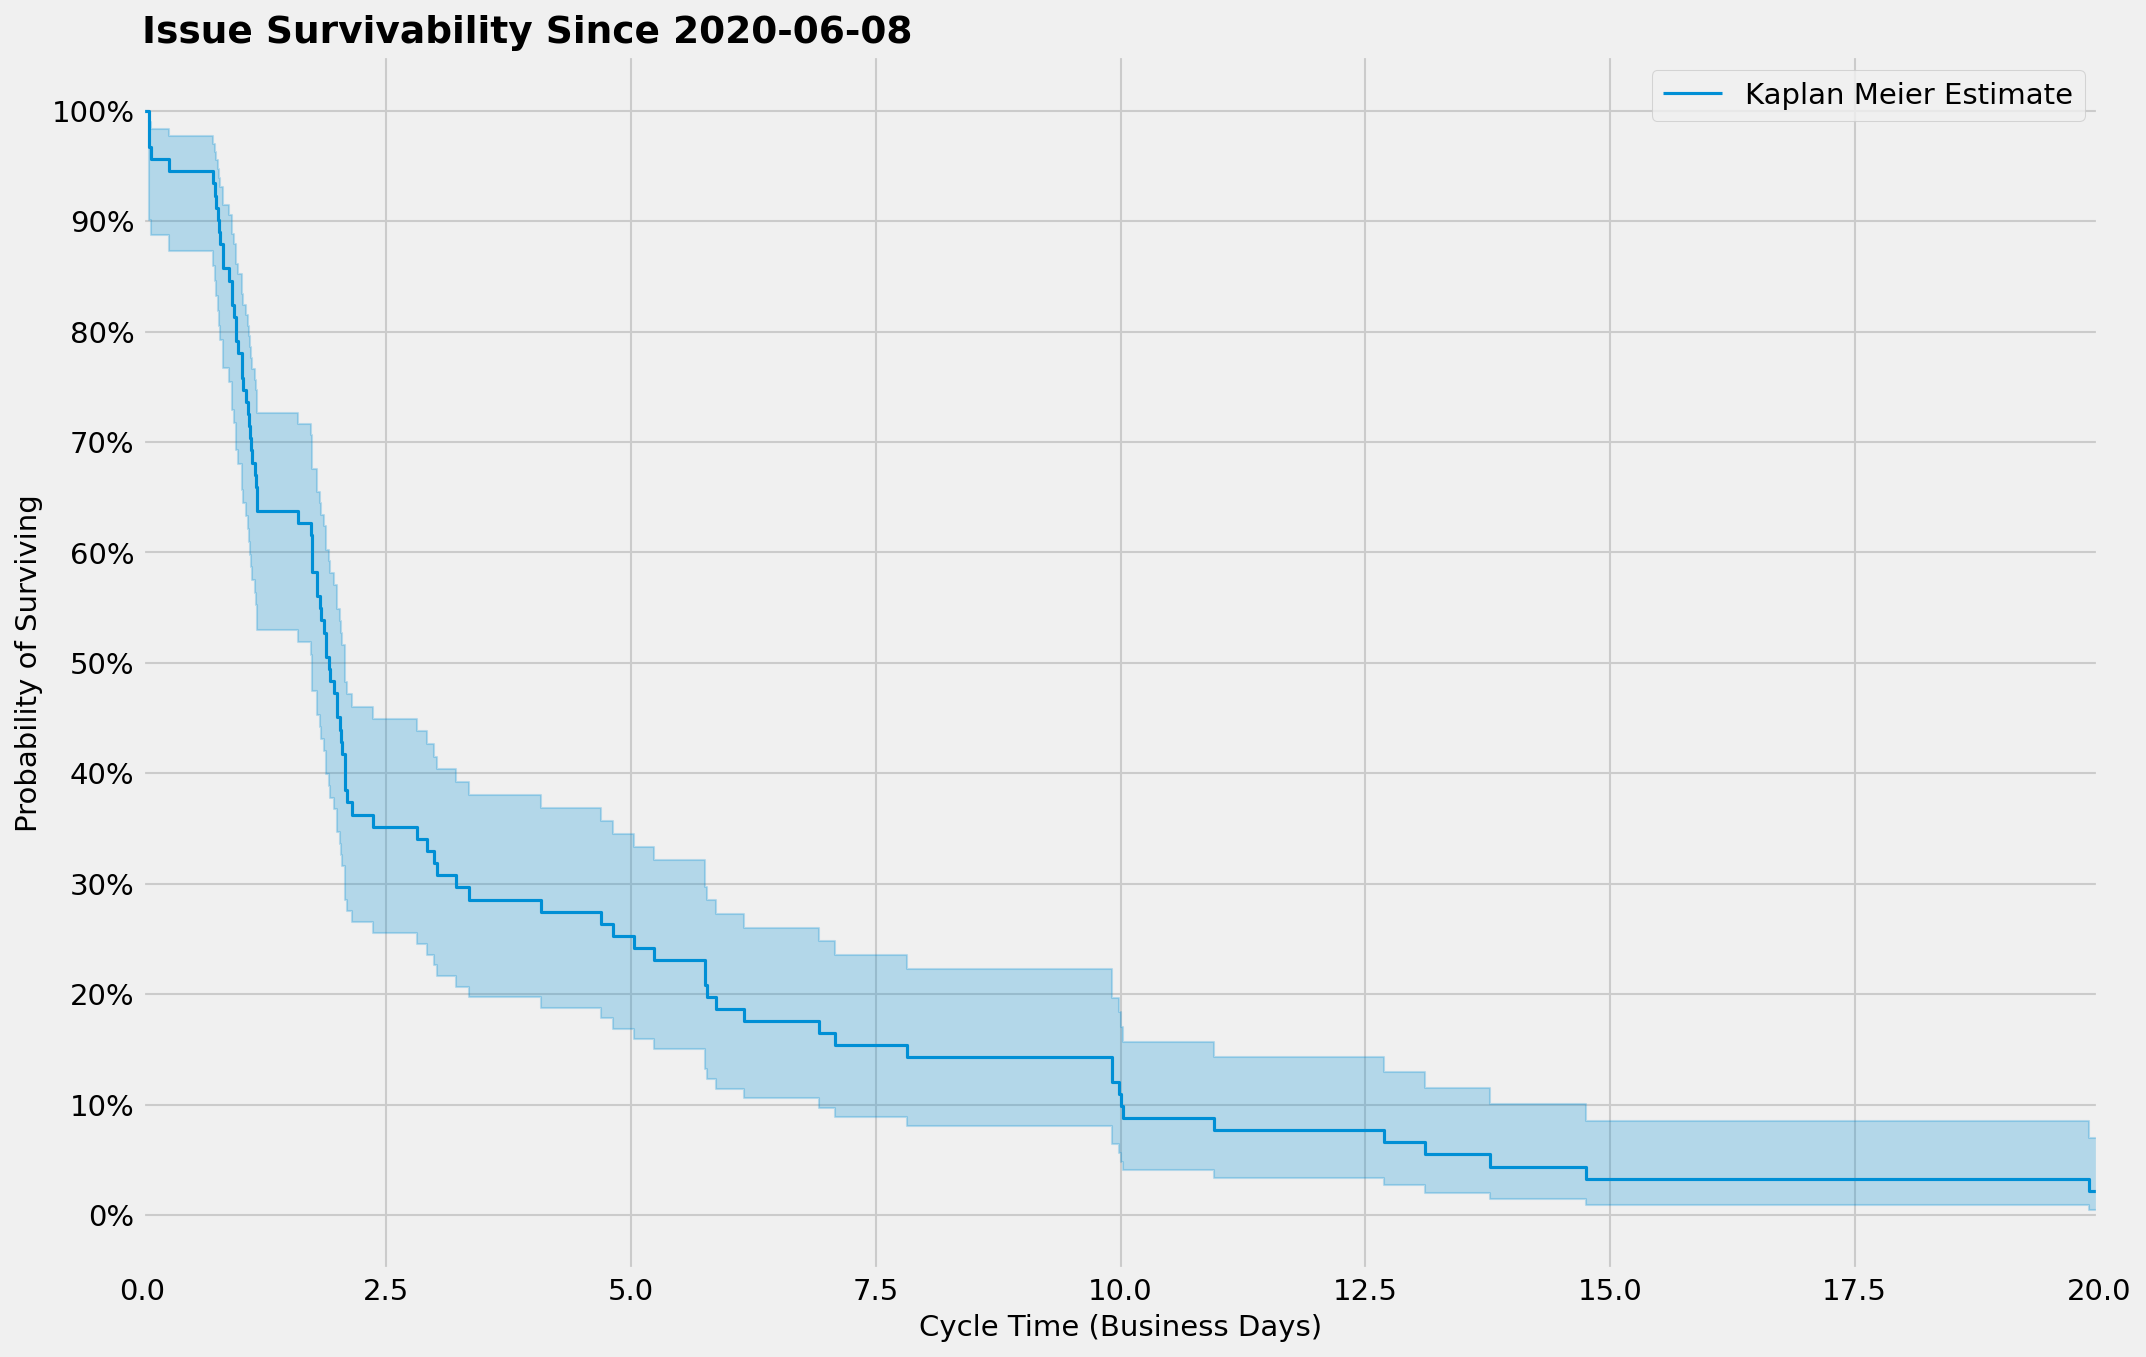

In [38]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = km.plot()

ax.set_title('Issue Survivability Since {}'.format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_yticks([i/100.0 for i in range(0,110,10)])
def format_func(value, tick_number):
    return '{}%'.format(int(value*100))
ax.set_xlim([0, 20])
ax.yaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))
ax.set_ylabel('Probability of Surviving')
_ = ax.set_xlabel('Cycle Time (Business Days)')

In [39]:
ax.figure.savefig('images/forecast-kaplan-meier.png')

*How do you read this graph?*

> The probability of an issue having a cycle time > 10 days (i.e., surviving past 10 days) is just over 10%.

### Weibull Analysis

We can also use the survivability data and fit it to a Weibull distribution. This will allow us to determine some reliability characteristics and trends of the population based on the sample.

In [40]:
from lifelines import WeibullFitter

survivability_data = issue_data.copy()
survivability_data = survivability_data[survivability_data['complete_day'] >= pandas.to_datetime(FILTER_ISSUES_SINCE)]

durations = [c if c else 0.00001 for c in survivability_data['cycle_time_days']]
event_observed = [1 if c else 0 for c in survivability_data['cycle_time_days']]

w = WeibullFitter()

## Fit the data into the model
w.fit(durations, event_observed, label='Weibull Analysis')
w.print_summary()

<lifelines.WeibullFitter:"Weibull Analysis", fitted with 101 total observations, 10 right-censored observations>
   number of observations = 101
number of events observed = 91
           log-likelihood = -215.24
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_   3.73       0.46             2.83             4.64  5.93 <0.005      28.27
rho_      0.90       0.07             0.76             1.03 -1.46   0.14       2.80
---
AIC = 434.49

Text(0.5, 0, 'Cycle Time (Business Days)')

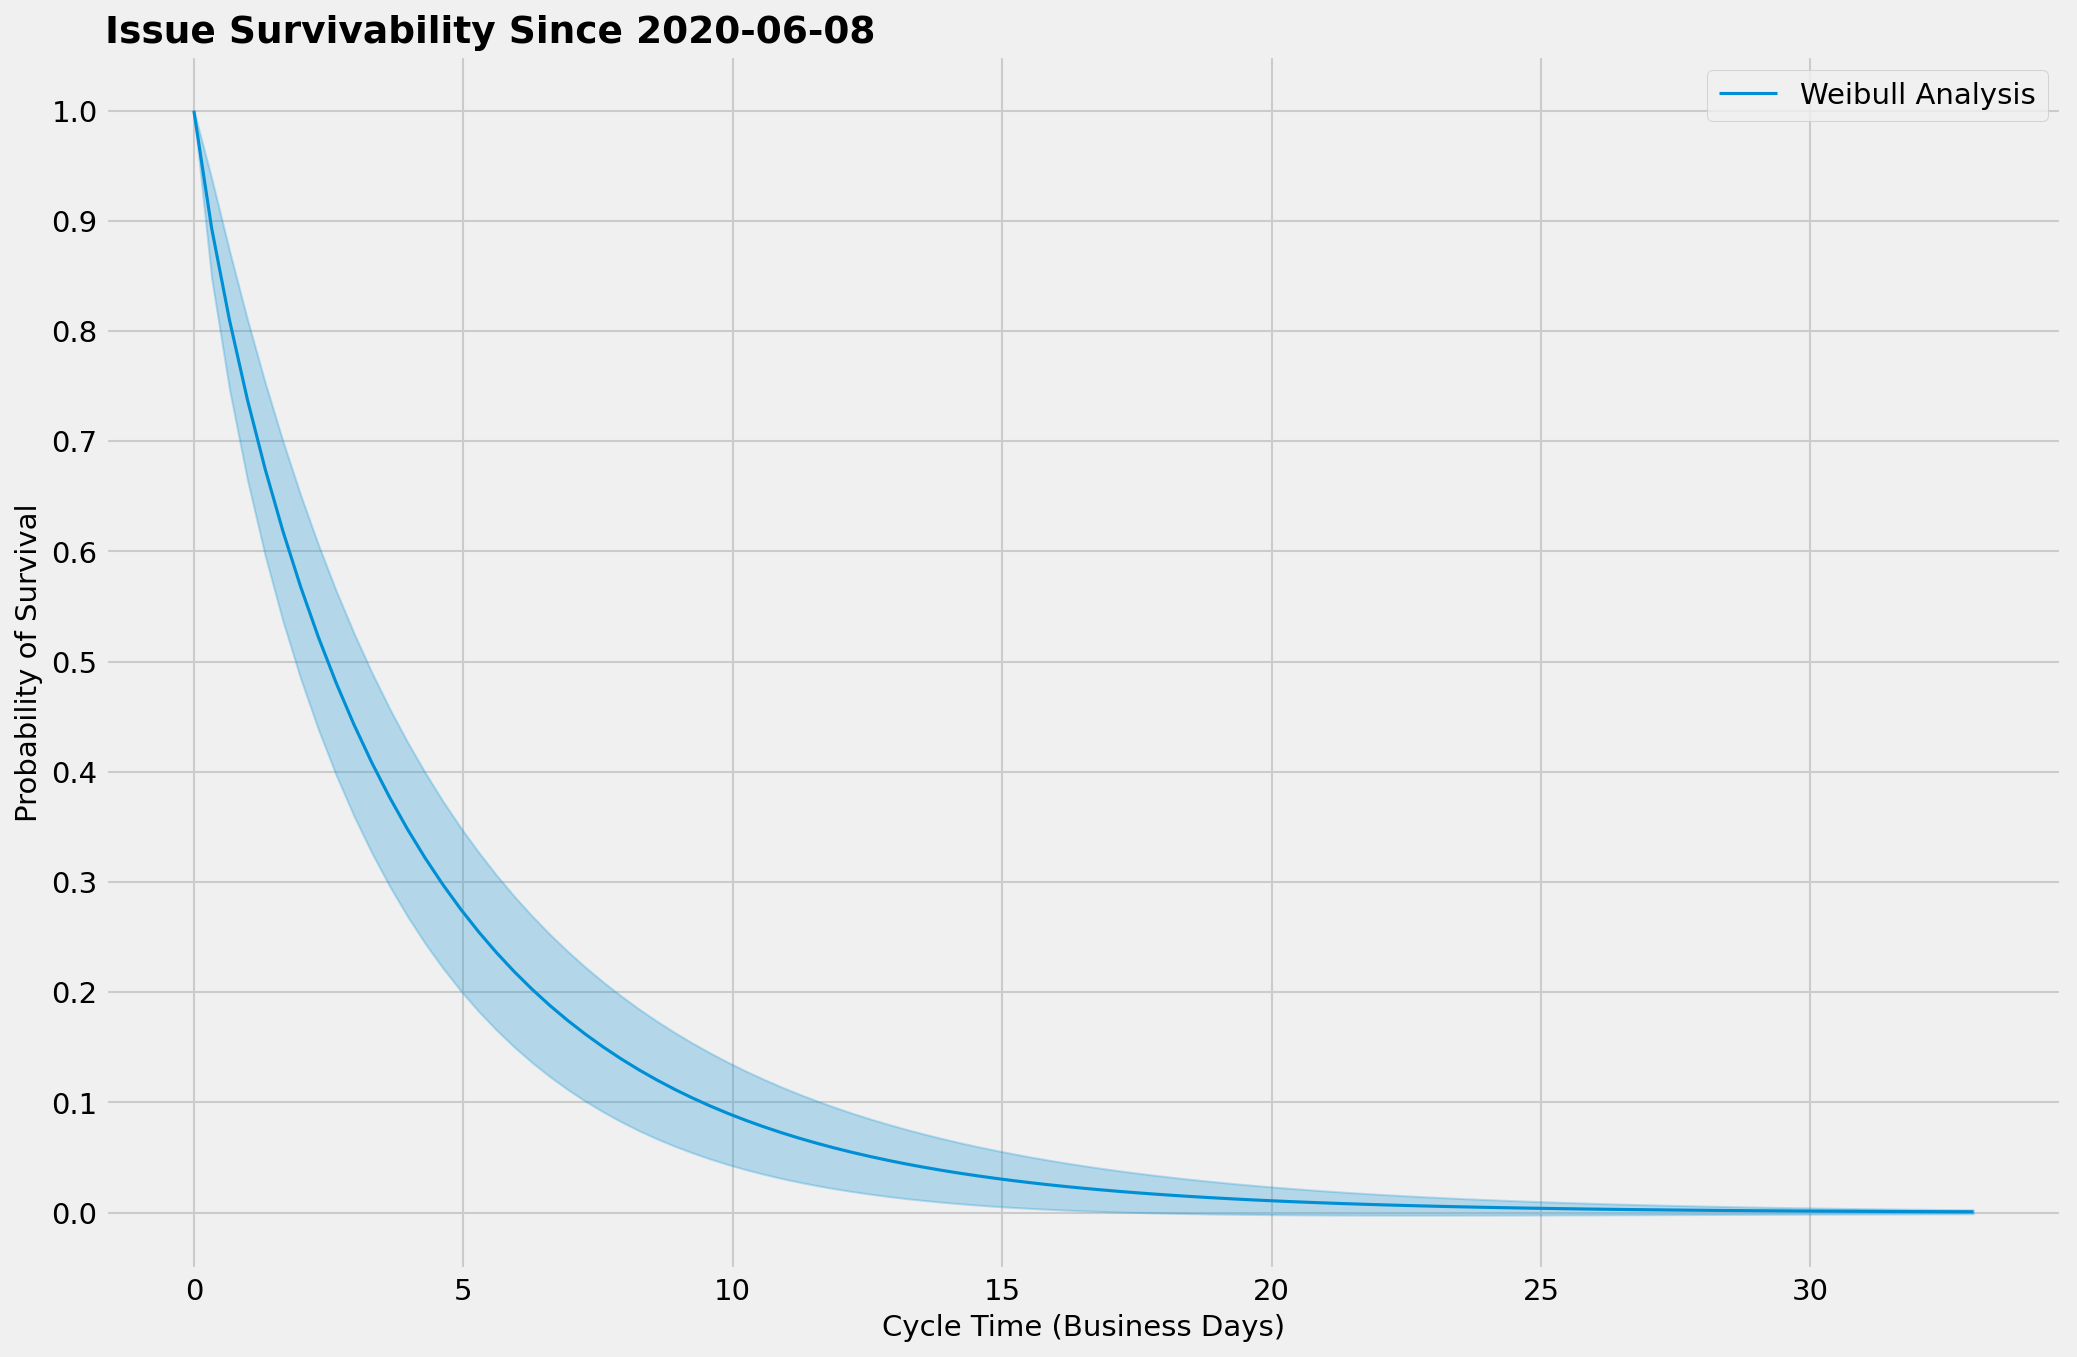

In [41]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = w.plot_survival_function()
ax.set_yticks([i/100.0 for i in range(0,110,10)])
ax.set_title('Issue Survivability Since {}'.format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_ylabel('Probability of Survival')
ax.set_xlabel('Cycle Time (Business Days)')

In [42]:
ax.figure.savefig('images/forecast-weibull-survival.png')

### Monte Carlo Simulation

So, what if you want to have a prediction of many issues over time (say, for instance, a batch of issues in an Epic)? We can use a Monte Carlo simulation based on our historical Kanban metrics to forecast the probability  of a batch of issues.

We can approach this forecast from two ways:

1. [WHEN]: By what date will N number of items be completed?
2. [HOW MANY]: How many items will be completed in the next N days?

#### [WHEN]: By what date will N number of items be completed?

The Monte Carlo simulation will use the historical distribution of throughput to forecast the future distribution of throughput.

With this simulation, we can compute how long it will take to complete N number of items if the historical distribution holds.

In [43]:
SIMULATION_ITEMS = 10 # N
SIMULATIONS = 10000
LAST_DAYS = 90
START_DATE = pandas.to_datetime('today')

In [44]:
def simulate_days(data, scope):
    days = 0
    total = 0
    while total <= scope:
        total += data.sample(n=1).iloc[0]['Throughput']
        days += 1
    completion_date = START_DATE + pandas.Timedelta(days, unit='d')
    return completion_date


dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)

samples = [simulate_days(dataset, SIMULATION_ITEMS)
           for i in range(SIMULATIONS)]

samples = pandas.DataFrame(samples, columns=['Date'])

distribution_when = samples.groupby(['Date']).size().reset_index(name='Frequency')

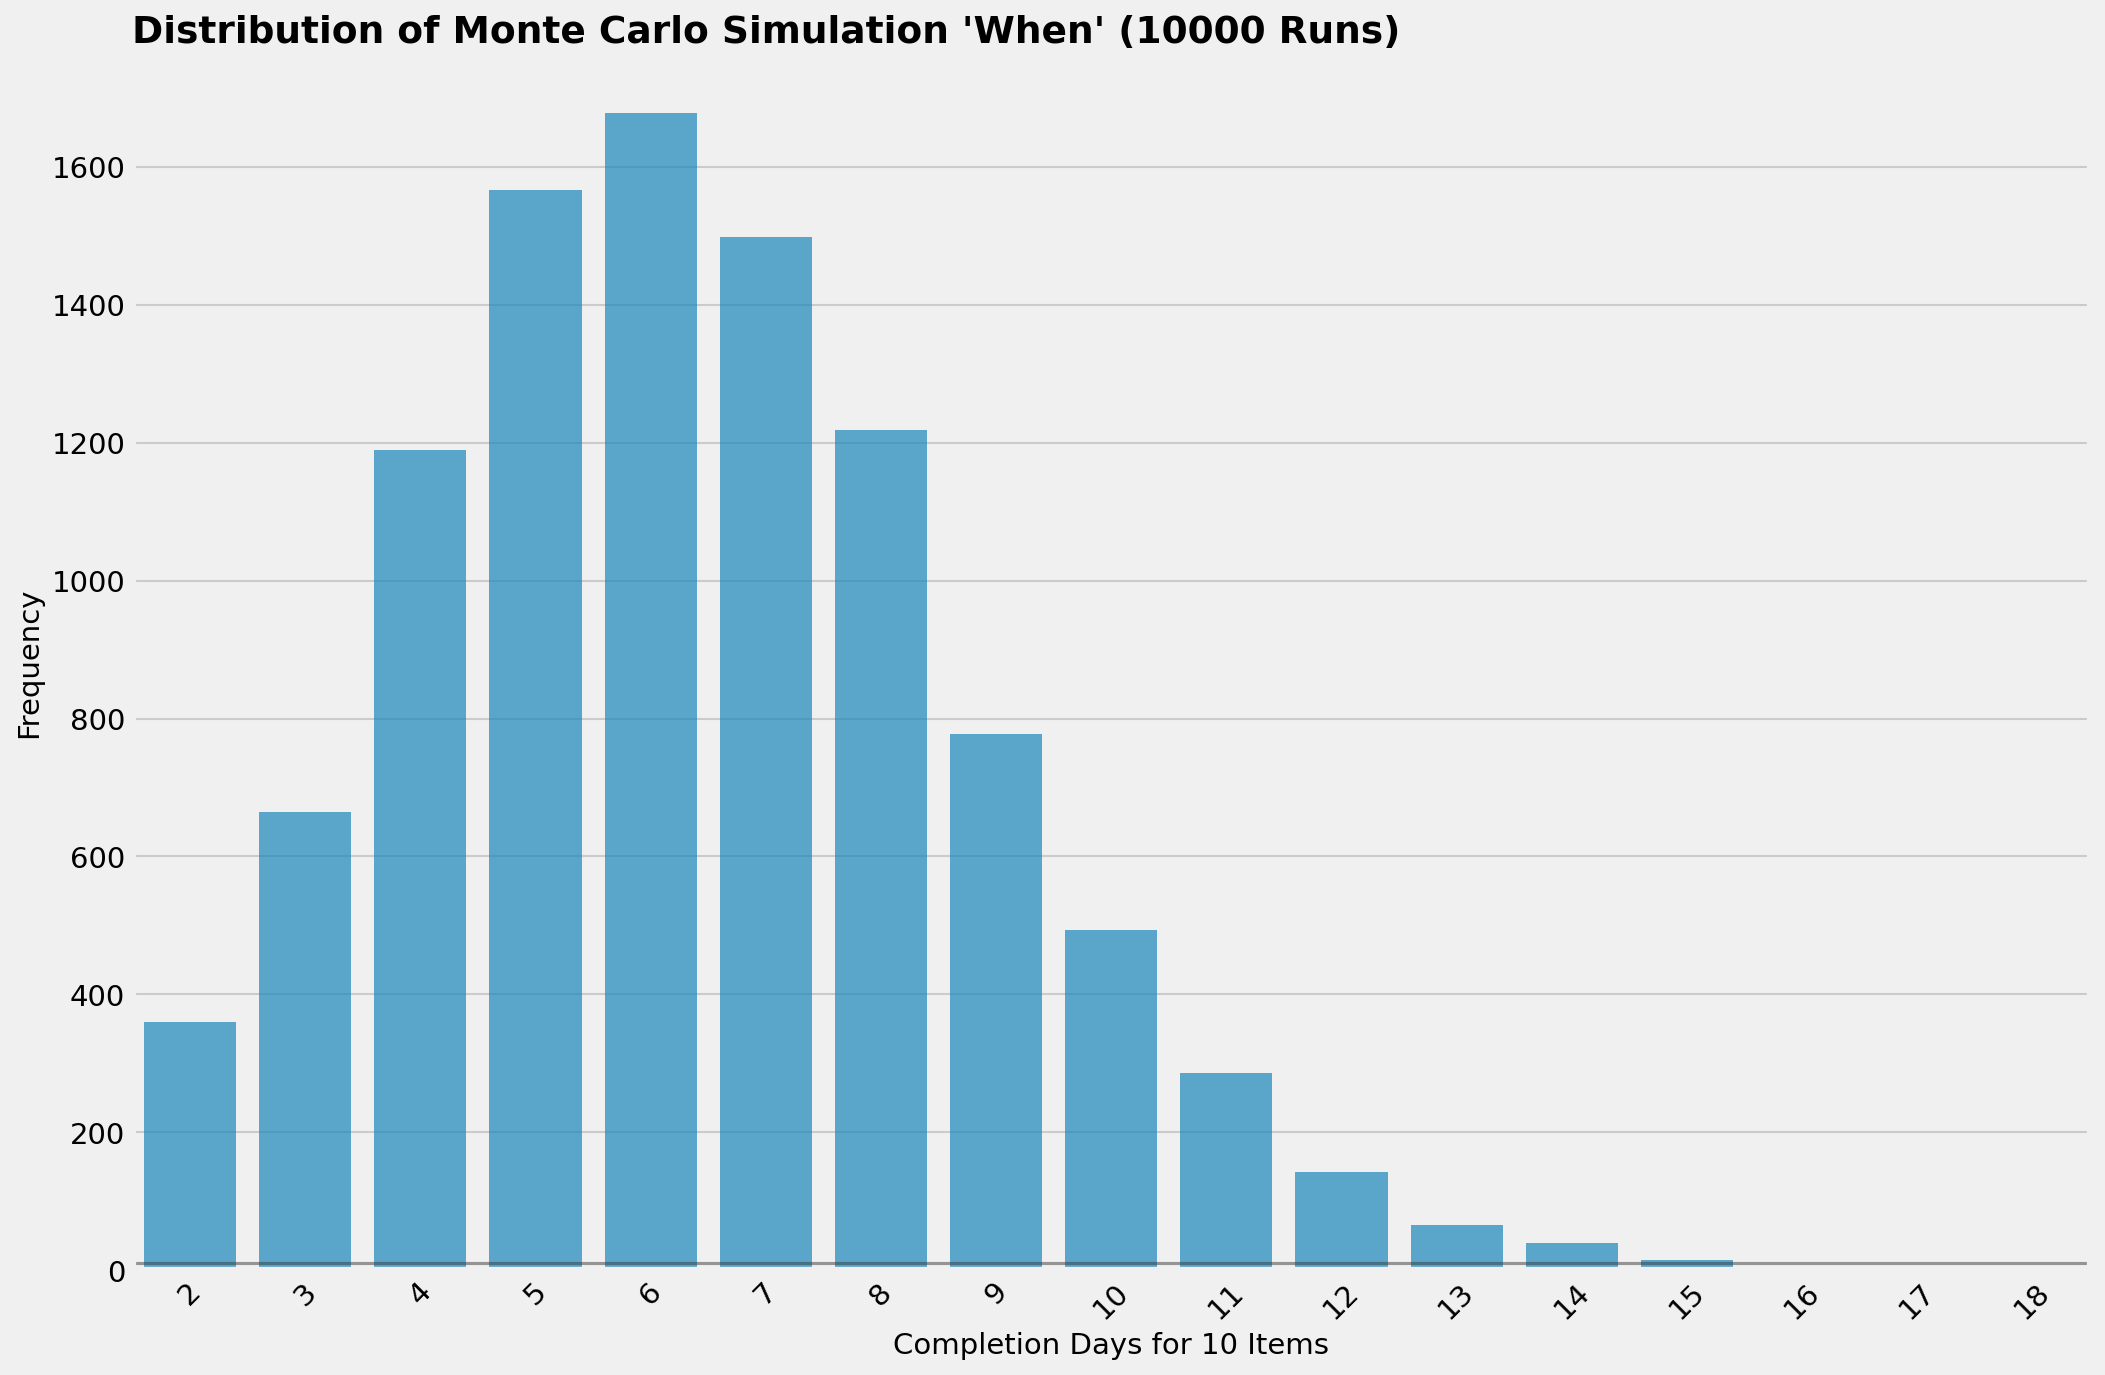

In [45]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Date', y='Frequency', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})

ax.set_xlabel(f"Completion Days for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')

unique_dates = sorted(list(distribution_when['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)

ax.set_xticks(date_ticks)

ax.set_xticklabels([
    (unique_dates[i] - START_DATE).days
                    for i in date_ticks], rotation=45)

ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

In [46]:
ax.figure.savefig('images/distribution-montecarlo-when.png')

Then, we can analyze the probability of completion based on this distribution.

In [47]:
distribution_when = distribution_when.sort_index(ascending=False)
distribution_when['Probability'] = 100 - 100 * \
    distribution_when.Frequency.cumsum()/distribution_when.Frequency.sum()

[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '8'),
 Text(7, 0, '9'),
 Text(8, 0, '10'),
 Text(9, 0, '11'),
 Text(10, 0, '12'),
 Text(11, 0, '13'),
 Text(12, 0, '14'),
 Text(13, 0, '15'),
 Text(14, 0, '16'),
 Text(15, 0, '17'),
 Text(16, 0, '18')]

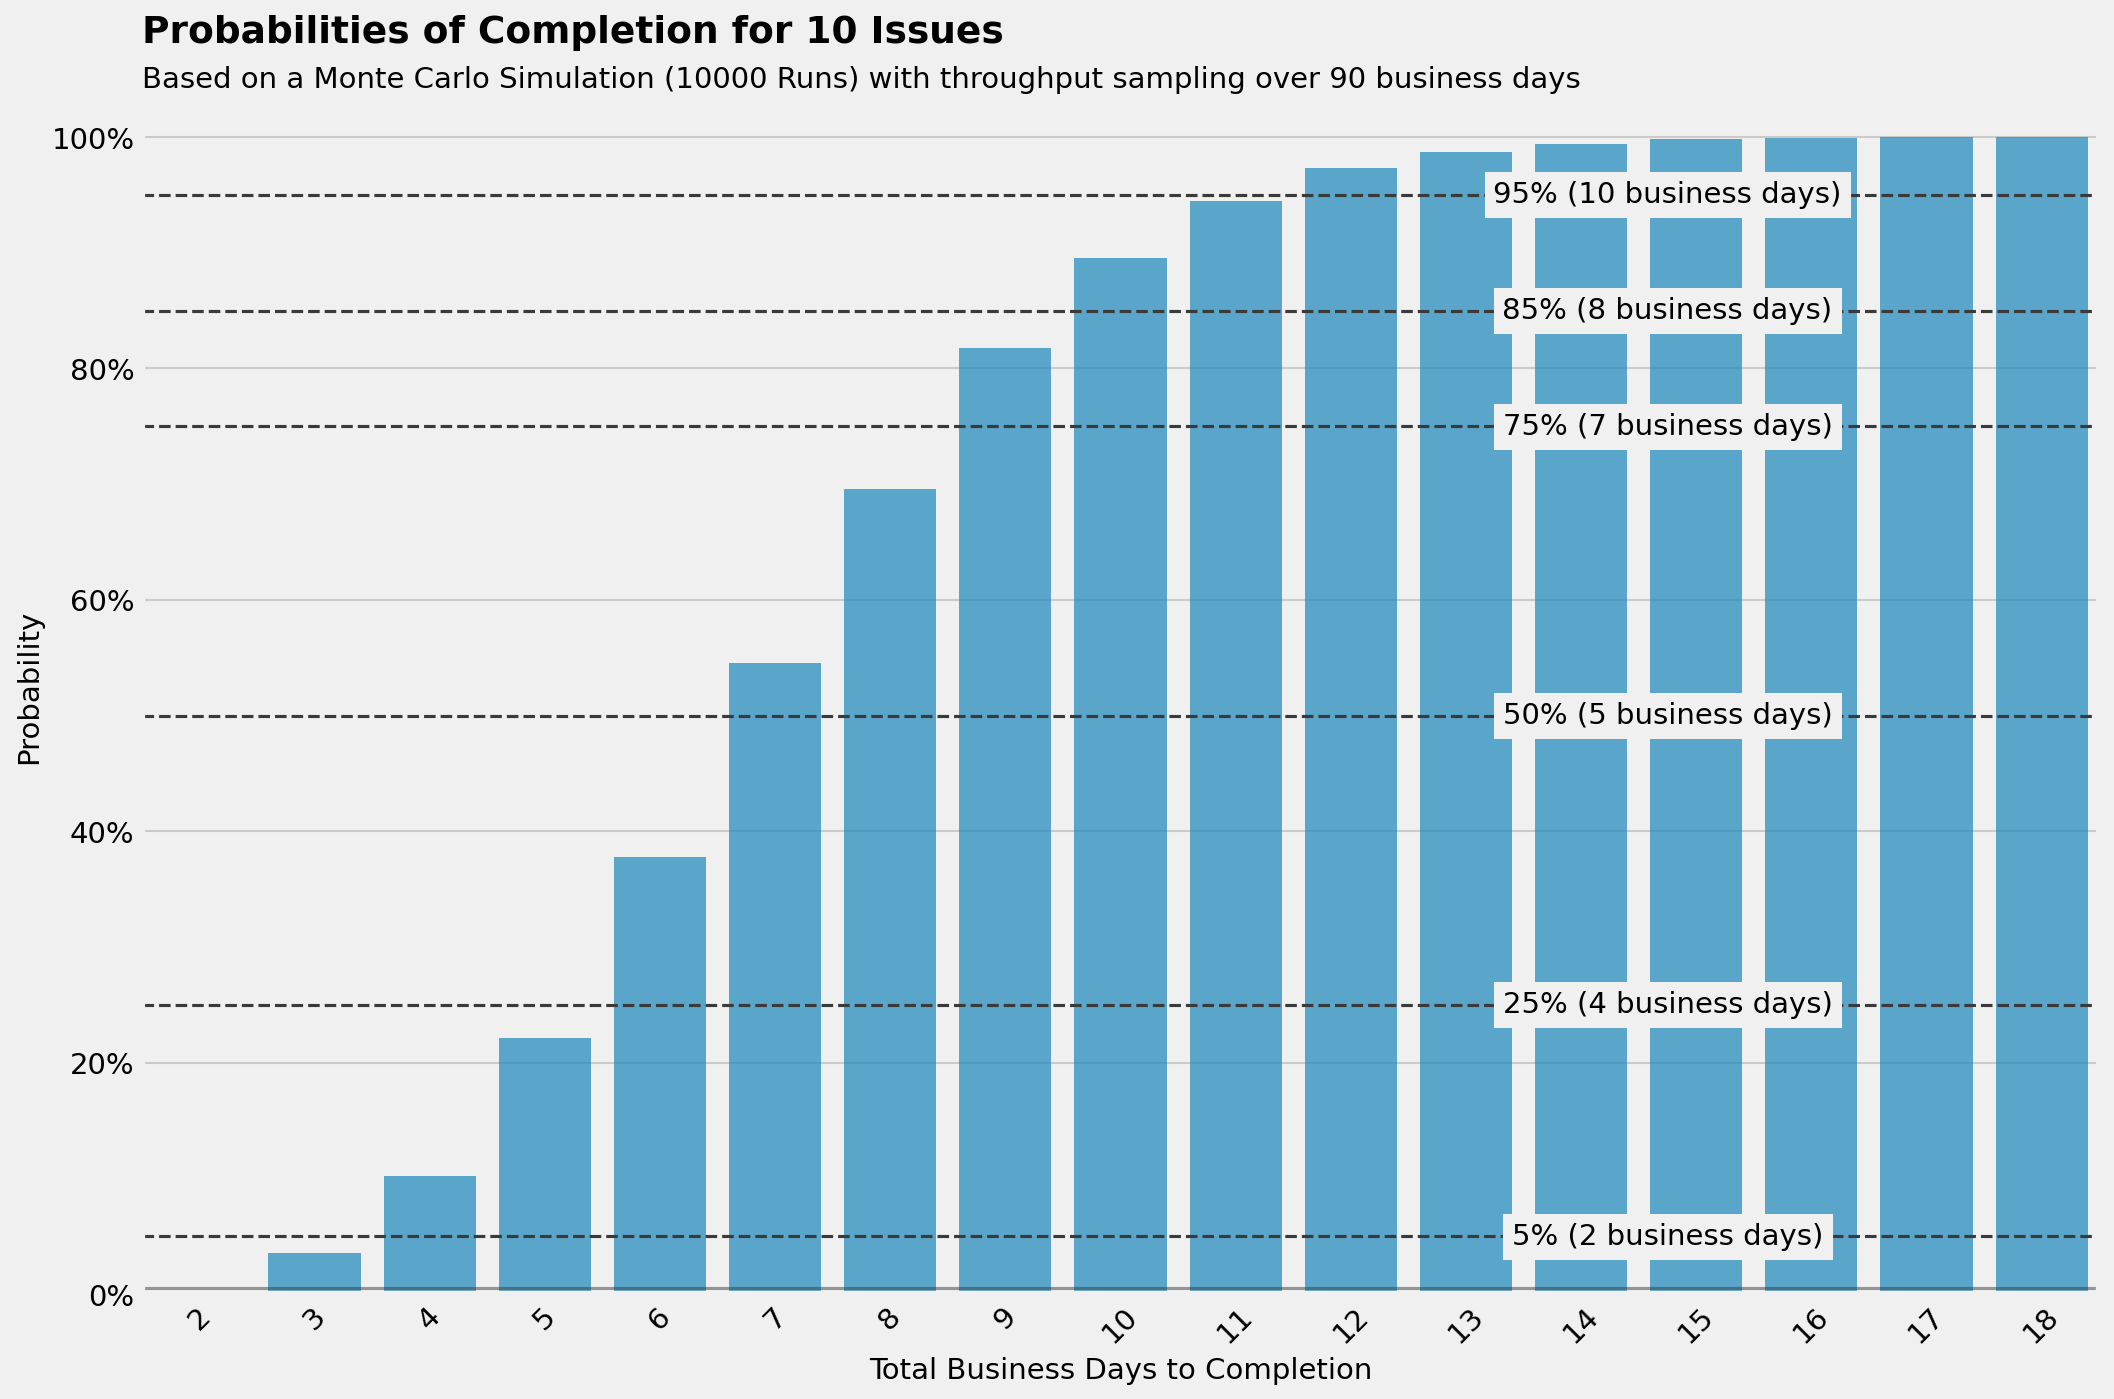

In [48]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Date', y='Probability', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Probabilities of Completion for {SIMULATION_ITEMS} Issues", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'semibold'})

ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} business days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Business Days to Completion')
ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=5, color=darkgrey, linestyle='--')
ax.axhline(y=25, color=darkgrey, linestyle='--')
ax.axhline(y=50, color=darkgrey, linestyle='--')
ax.axhline(y=75, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')

unique_dates = sorted(list(distribution_when['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)

xpos = 0.75 * len(unique_dates)

include_date = False

if include_date:
    ax.text(y=5, x=xpos, s=f"5% ({(samples.Date.quantile(0.05) - START_DATE).days} business days, {samples.Date.quantile(0.05).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=25, x=xpos, s=f"25% ({(samples.Date.quantile(0.25) - START_DATE).days} business days, {samples.Date.quantile(0.25).strftime('%Y-%m-%d')})",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=50, x=xpos, s=f"50% ({(samples.Date.quantile(0.5) - START_DATE).days} business days, {samples.Date.quantile(0.5).strftime('%Y-%m-%d')})",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=75, x=xpos, s=f"75% ({(samples.Date.quantile(0.75) - START_DATE).days} business days, {samples.Date.quantile(0.75).strftime('%Y-%m-%d')})",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=85, x=xpos, s=f"85% ({(samples.Date.quantile(0.75) - START_DATE).days} business days, {samples.Date.quantile(0.85).strftime('%Y-%m-%d')})",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=95, x=xpos, s=f"95% ({(samples.Date.quantile(0.95) - START_DATE).days} business days, {samples.Date.quantile(0.95).strftime('%Y-%m-%d')})",
            va='center', ha='center', backgroundcolor='#F0F0F0')
else:
    ax.text(y=5, x=xpos, s=f"5% ({(samples.Date.quantile(0.05) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=25, x=xpos, s=f"25% ({(samples.Date.quantile(0.25) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=50, x=xpos, s=f"50% ({(samples.Date.quantile(0.5) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=75, x=xpos, s=f"75% ({(samples.Date.quantile(0.75) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=85, x=xpos, s=f"85% ({(samples.Date.quantile(0.85) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')
    ax.text(y=95, x=xpos, s=f"95% ({(samples.Date.quantile(0.95) - START_DATE).days} business days)",
            va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%'])

ax.set_xticks(date_ticks)

ax.set_xticklabels([
    (unique_dates[i] - START_DATE).days
                    for i in date_ticks], rotation=45)


In [49]:
ax.figure.savefig('images/forecast-montecarlo-when.png')

#### [HOW MANY]: How many items will be completed in the next N days?

The Monte Carlo simulation will use the historical distribution of throughput to forecast the future distribution of throughput.

With this simulation, we can compute how many items will be completed in the next N days if the historical distribution holds.

In [50]:
SIMULATION_DAYS = 10 # N
SIMULATIONS = 10000
LAST_DAYS = 90

In [51]:
dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum()['Throughput'] for i in range(SIMULATIONS)]
samples = pandas.DataFrame(samples, columns=['Items'])
distribution_how = samples.groupby(['Items']).size().reset_index(name='Frequency')

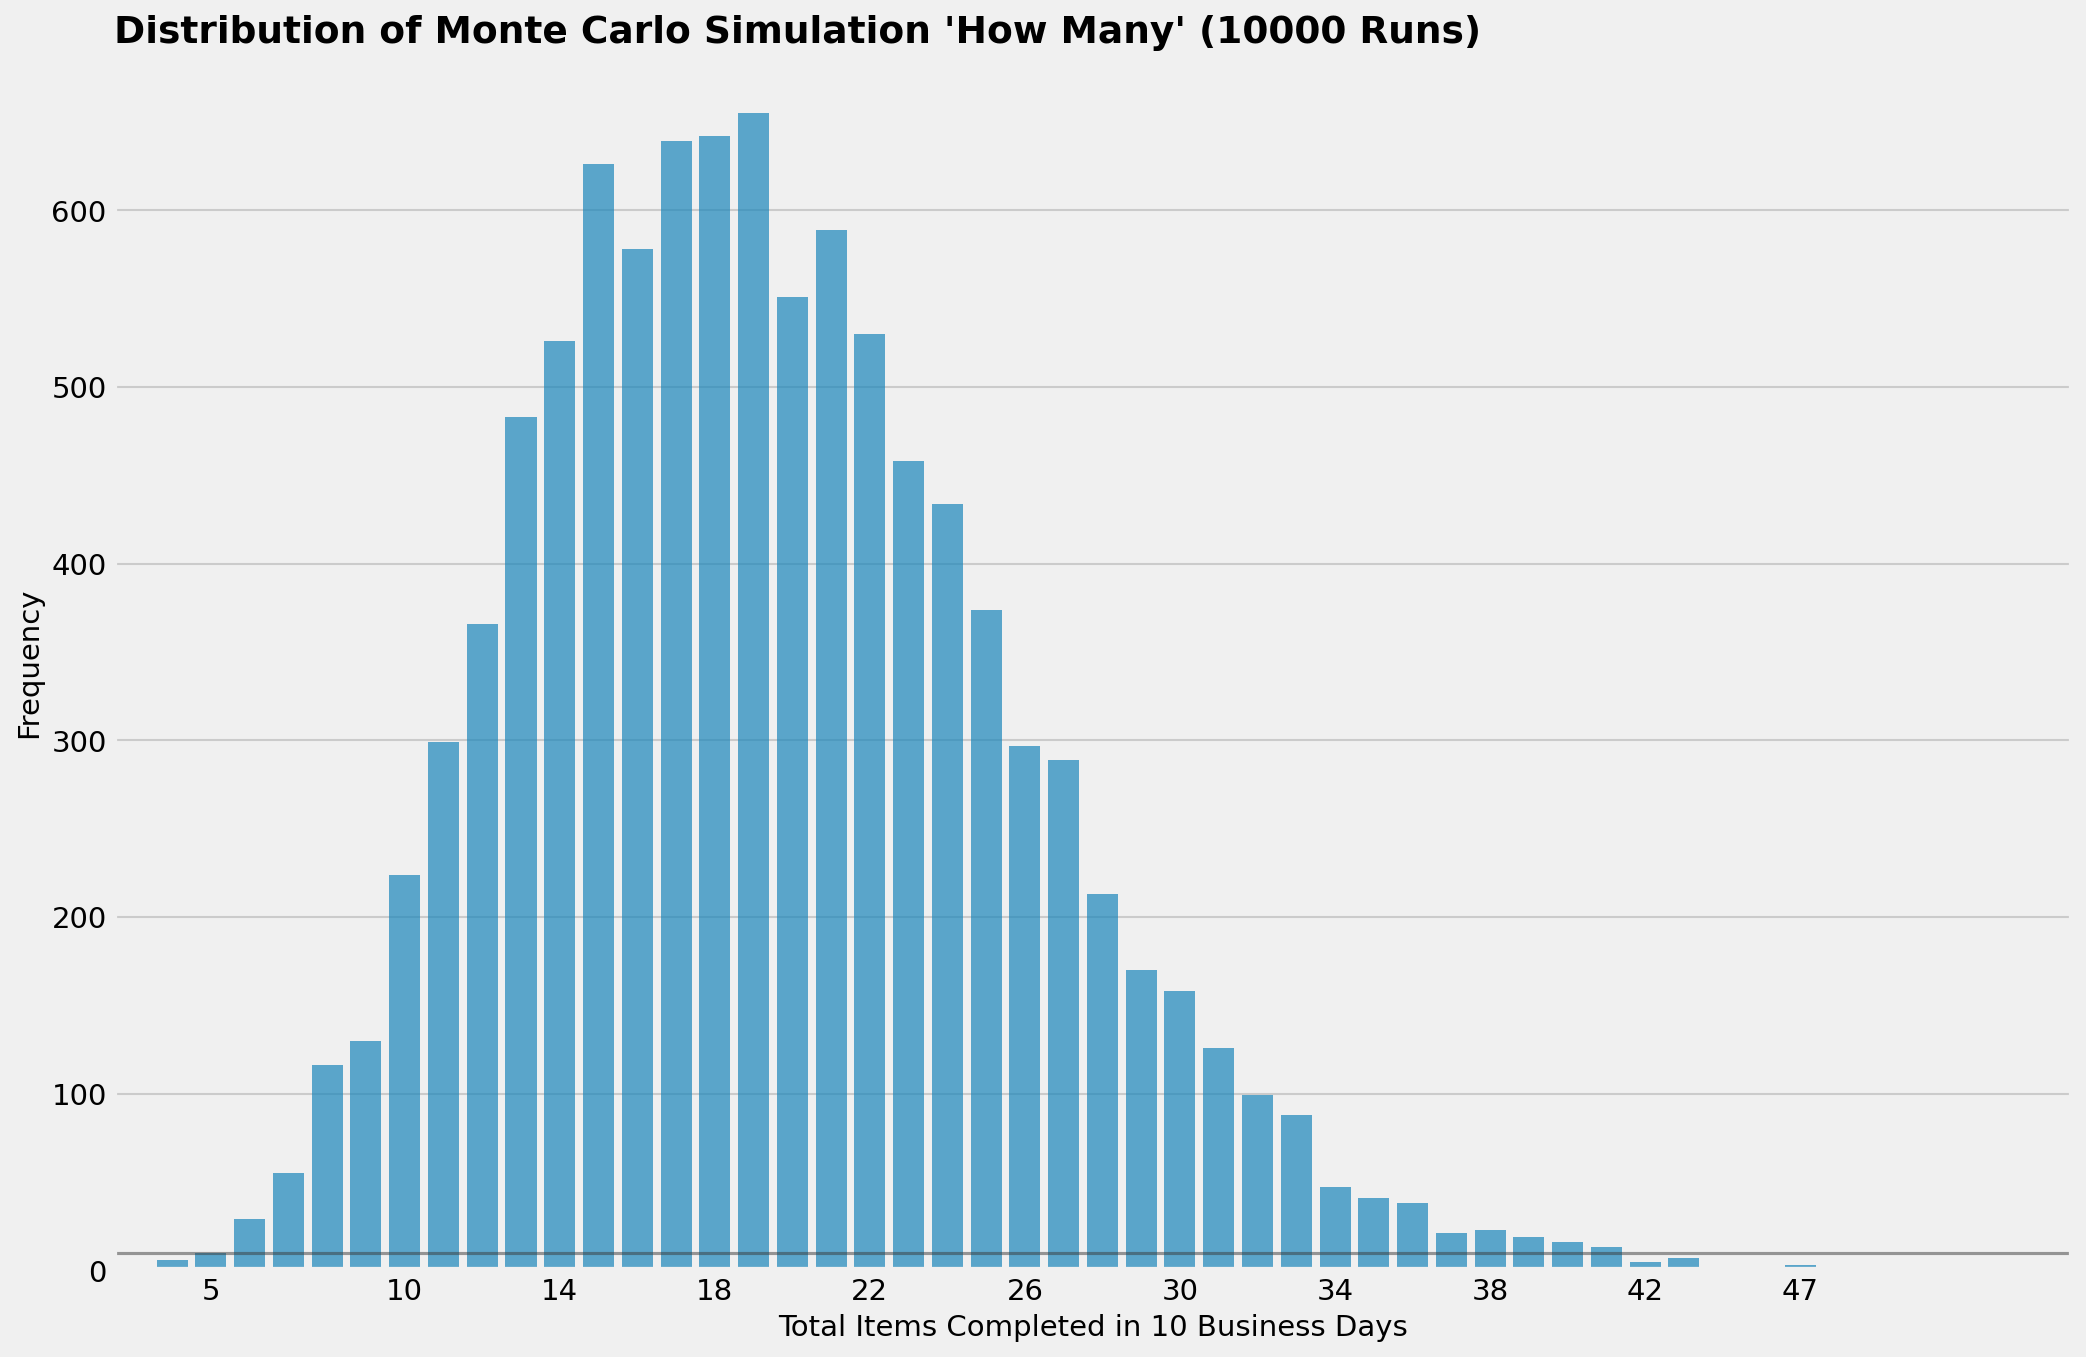

In [52]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Frequency', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})

ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Business Days")
ax.set_ylabel('Frequency')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

In [53]:
ax.figure.savefig('images/distribution-montecarlo-how.png')

Then, we can analyze the probability of completion based on this distribution.

In [54]:
distribution_how = distribution_how.sort_index(ascending=False)
distribution_how['Probability'] = 100 * \
    distribution_how.Frequency.cumsum()/distribution_how.Frequency.sum()

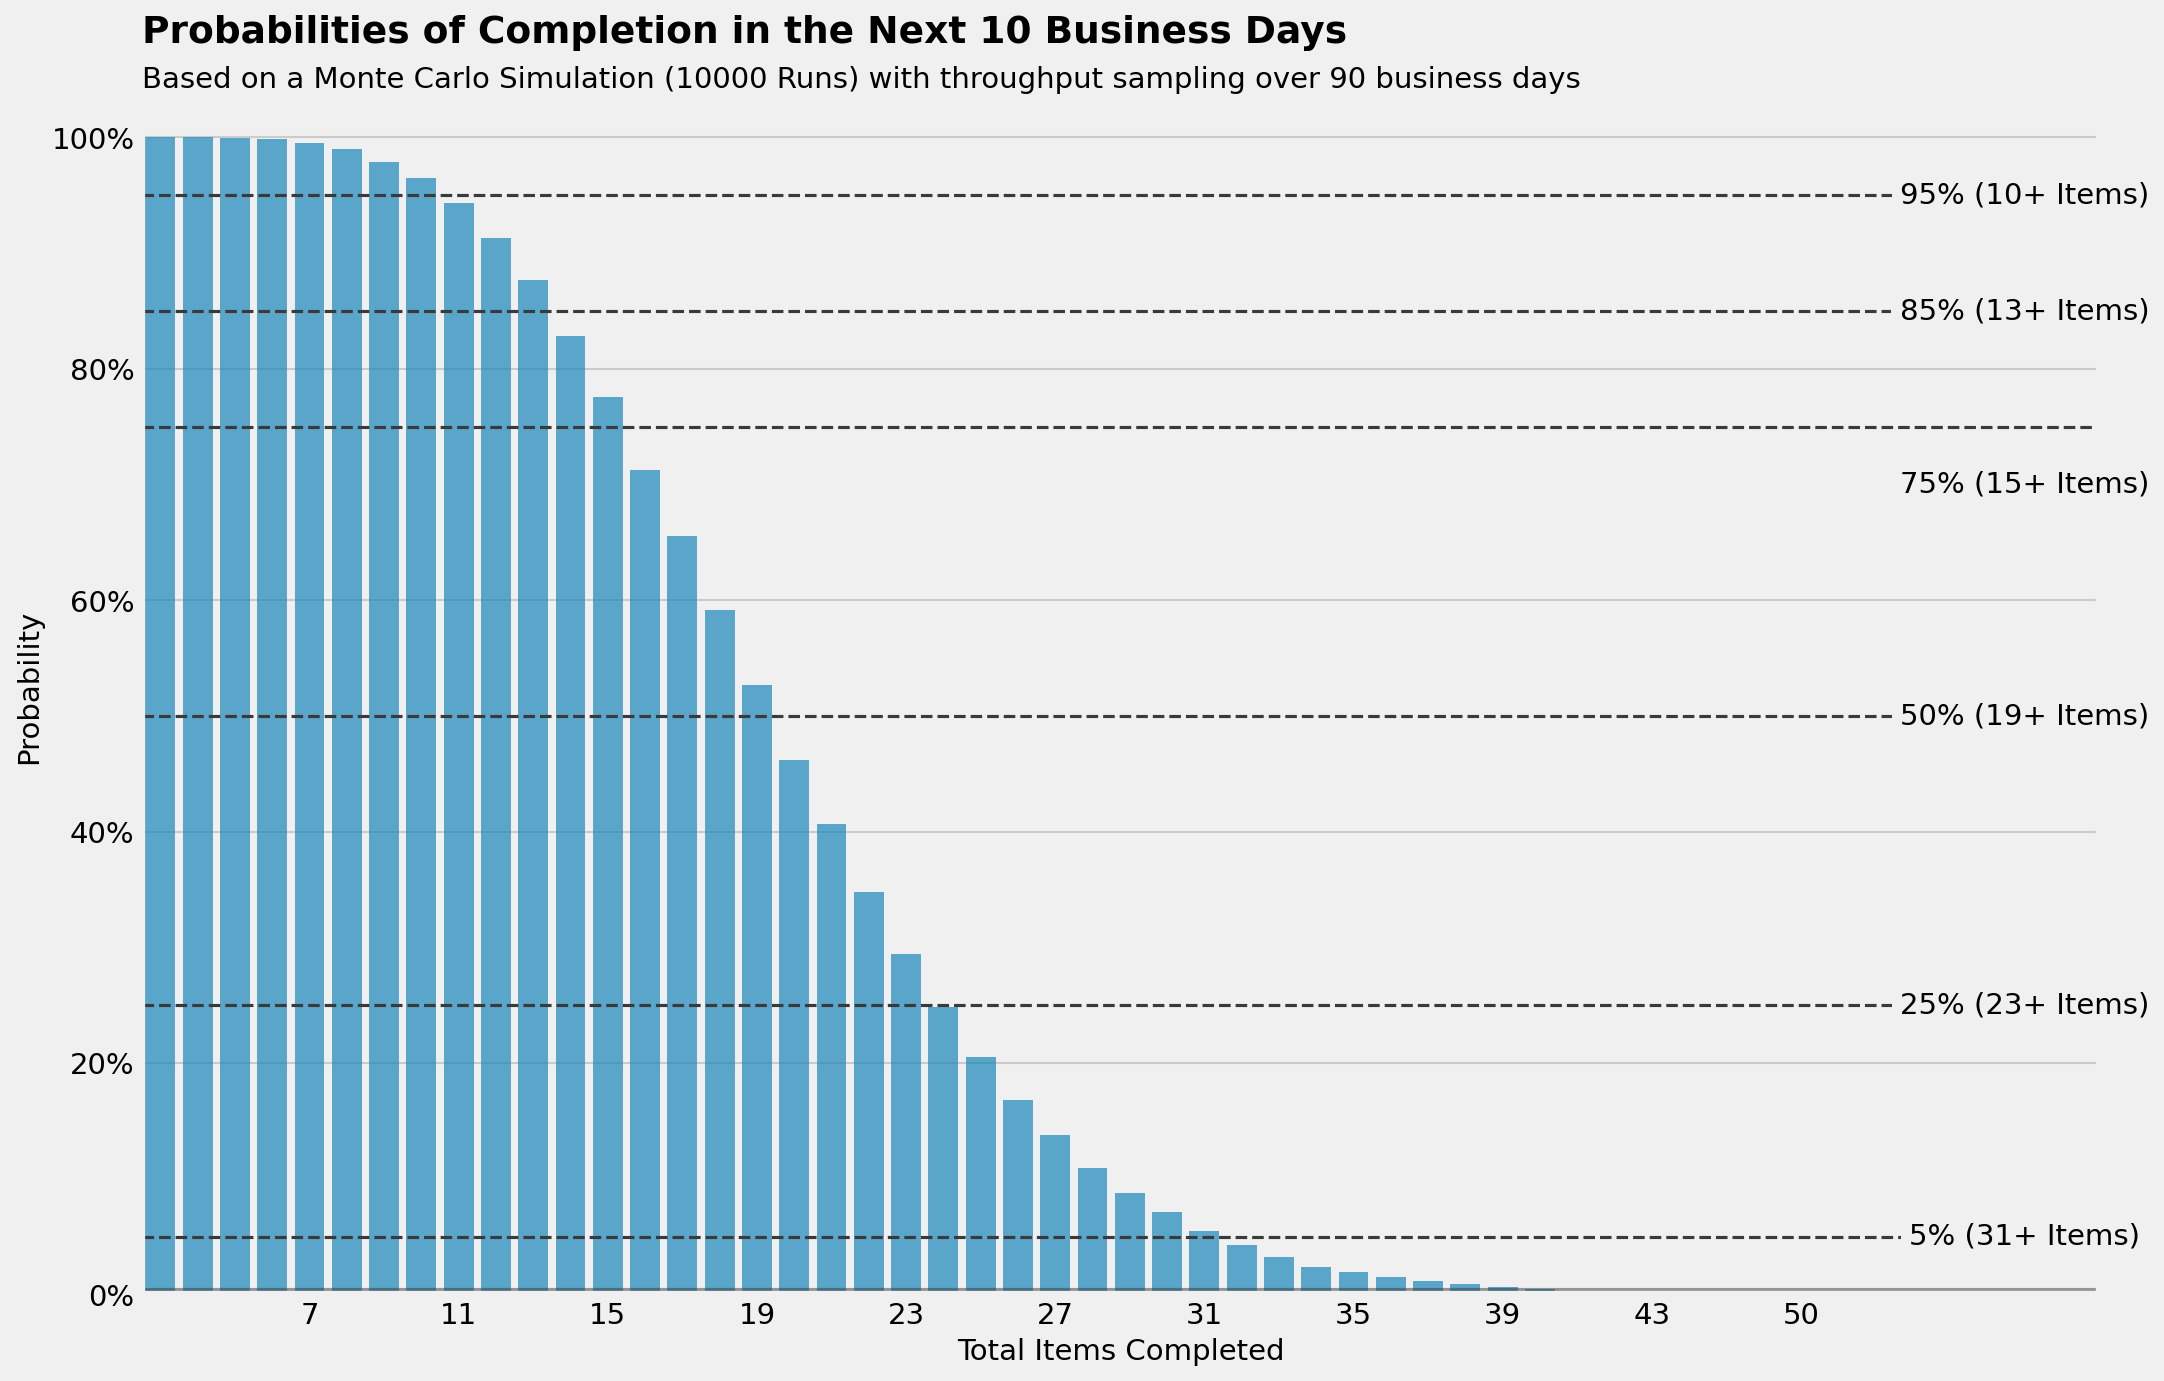

In [55]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Probability', data=distribution_how, color='C0', alpha=0.7)


ax.set_title(f"Probabilities of Completion in the Next {SIMULATION_DAYS} Business Days", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'semibold'})
ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} business days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Items Completed')

ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=5, color=darkgrey, linestyle='--')
ax.axhline(y=25, color=darkgrey, linestyle='--')
ax.axhline(y=50, color=darkgrey, linestyle='--')
ax.axhline(y=75, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')

label_xpos = distribution_how['Items'].max()-2

ax.text(y=5, x=label_xpos, s=f'5%% (%d+ Items)' % samples.Items.quantile(0.95),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=label_xpos, s=f'25%% (%d+ Items)' % samples.Items.quantile(0.75),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=label_xpos, s=f'50%% (%d+ Items)' % samples.Items.quantile(0.5),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=70, x=label_xpos, s=f'75%% (%d+ Items)' % samples.Items.quantile(0.25),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%']);

In [56]:
ax.figure.savefig('images/forecast-montecarlo-how.png')

#### [HOW MANY]: How many points (velocity) will be completed in the next N days?

It may also be useful to use a Monte Carlo simulation against velocity instead of just throughput.

The Monte Carlo simulation will use the historical distribution of velocity to forecast the future distribution of velocity.

With this simulation, we can compute how many points will be completed in the next N days if the historical distribution of velocity holds. If your data doesn't include points, velocity will equal throughput, making this graph redundant.

In [57]:
SIMULATION_DAYS = 10 # N
SIMULATIONS = 10000
LAST_DAYS = 90

In [58]:
dataset = throughput[['Velocity']].tail(LAST_DAYS).reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum()['Velocity'] for i in range(SIMULATIONS)]
samples = pandas.DataFrame(samples, columns=['Points'])
distribution_how = samples.groupby(['Points']).size().reset_index(name='Frequency')

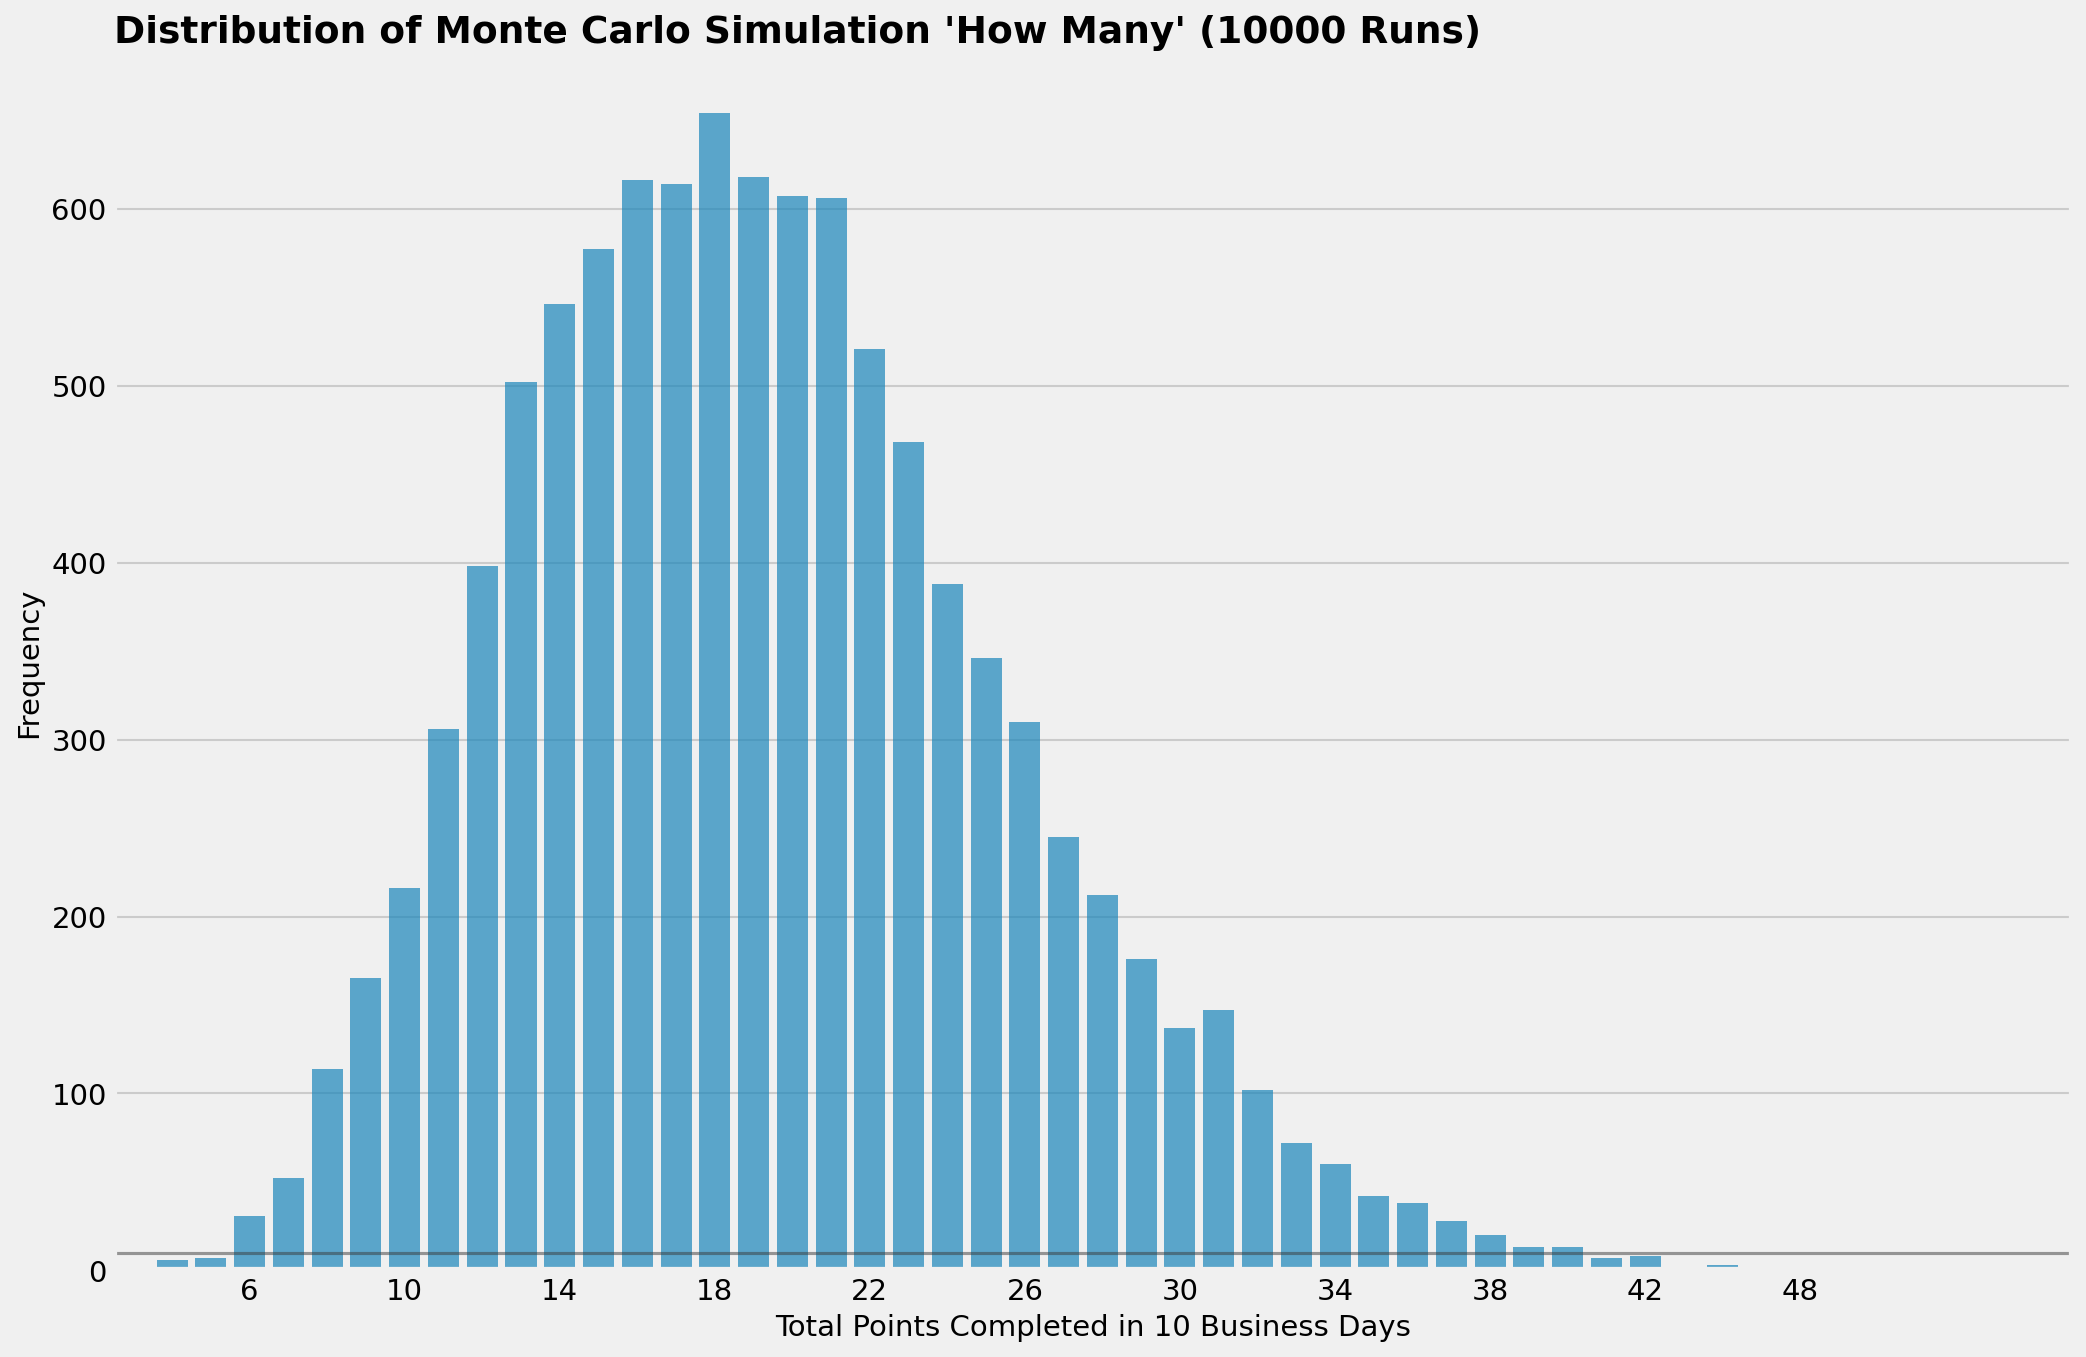

In [59]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Points', y='Frequency', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})

ax.set_xlabel(f"Total Points Completed in {SIMULATION_DAYS} Business Days")
ax.set_ylabel('Frequency')

ax.set_xticks(distribution_how['Points'][0::len(distribution_how['Points'])//10])

ax.axhline(y=SIMULATIONS*0.001, color=darkgrey, alpha=.5);

In [60]:
ax.figure.savefig('images/distribution-montecarlo-how-velocity.png')

Then, we can analyze the probability of completion based on this distribution.

In [61]:
distribution_how = distribution_how.sort_index(ascending=False)
distribution_how['Probability'] = 100 * \
    distribution_how.Frequency.cumsum()/distribution_how.Frequency.sum()

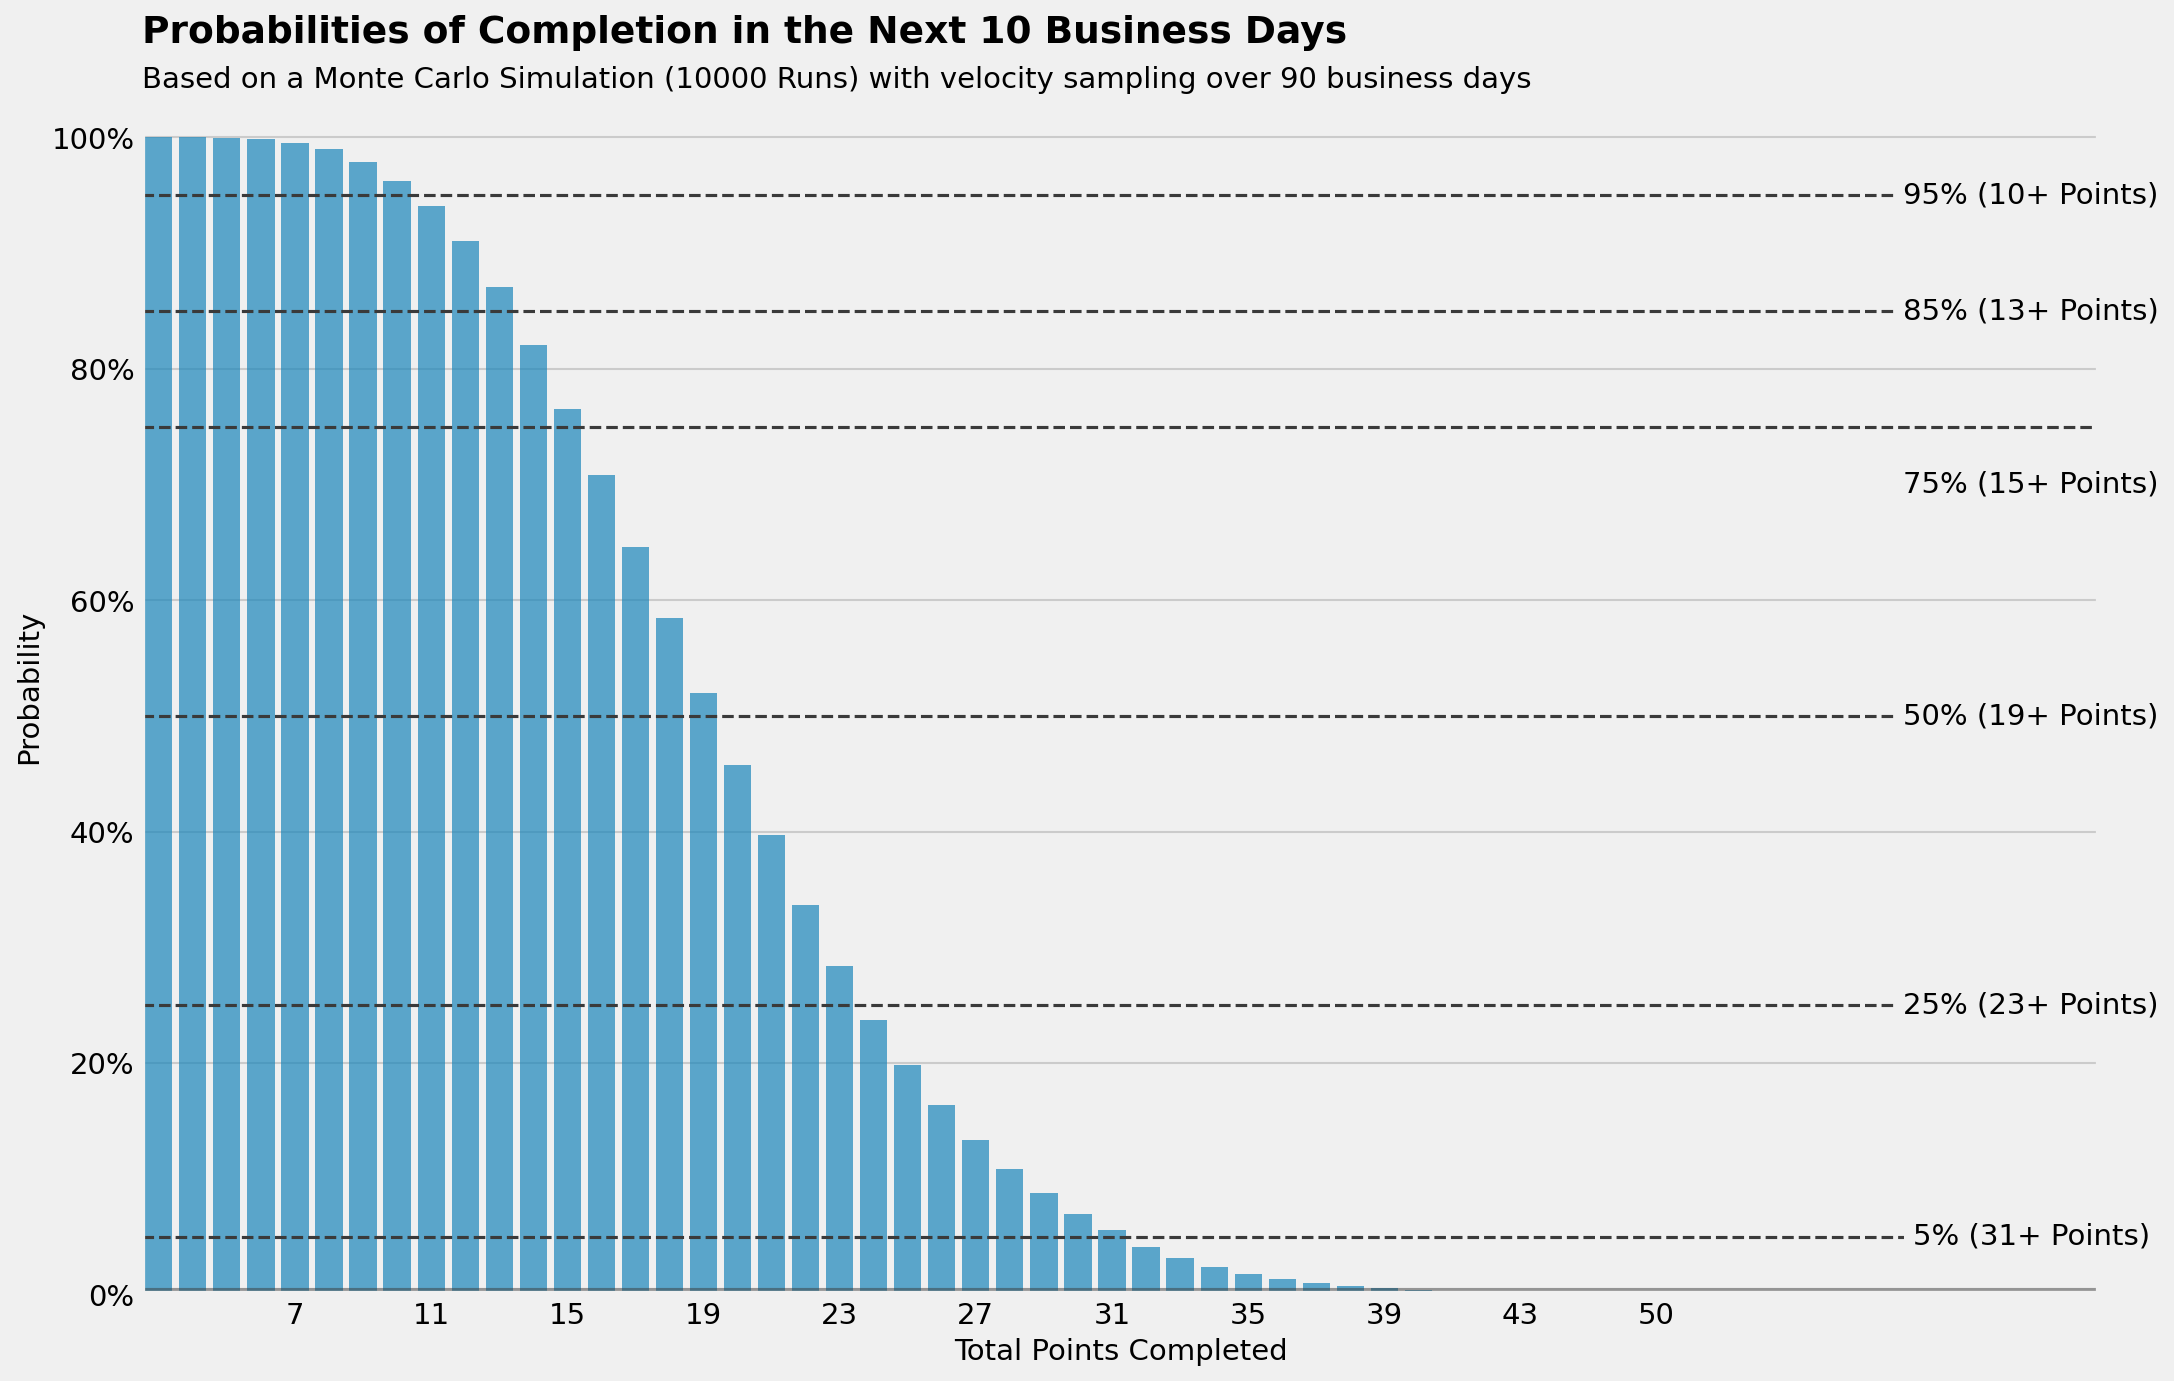

In [62]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Points', y='Probability', data=distribution_how, color='C0', alpha=0.7)


ax.set_title(f"Probabilities of Completion in the Next {SIMULATION_DAYS} Business Days", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'semibold'})
ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with velocity sampling over {LAST_DAYS} business days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Points Completed')

ax.axhline(y=0.5, color=darkgrey, alpha=.5)
ax.axhline(y=5, color=darkgrey, linestyle='--')
ax.axhline(y=25, color=darkgrey, linestyle='--')
ax.axhline(y=50, color=darkgrey, linestyle='--')
ax.axhline(y=75, color=darkgrey, linestyle='--')
ax.axhline(y=85, color=darkgrey, linestyle='--')
ax.axhline(y=95, color=darkgrey, linestyle='--')

label_xpos = distribution_how['Points'].max()-2

ax.text(y=5, x=label_xpos, s=f'5%% (%d+ Points)' % samples.Points.quantile(0.95),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=label_xpos, s=f'25%% (%d+ Points)' % samples.Points.quantile(0.75),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=label_xpos, s=f'50%% (%d+ Points)' % samples.Points.quantile(0.5),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=70, x=label_xpos, s=f'75%% (%d+ Points)' % samples.Points.quantile(0.25),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Points)' % samples.Points.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Points)' % samples.Points.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_xticks(distribution_how['Points'][0::len(distribution_how['Points'])//10])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%']);

In [63]:
ax.figure.savefig('images/forecast-montecarlo-how-velocity.png')